# Synthetic Data

In [1]:
import numpy as np
import pandas as pd
from numba import jit
import quantecon as qe
from joblib import Parallel, delayed
from typing import Dict, List, Tuple, Union

@jit(nopython=True)
def compute_log_returns(
    N: int,
    mu_vector: np.ndarray,
    kappa_vector: np.ndarray,
    theta_vector: np.ndarray,
    xi_vector: np.ndarray,
    dwS: np.ndarray,
    dwV: np.ndarray,
    Y: np.ndarray,
    n: np.ndarray,
    dt: float,
    sqrt_dt: float,
    lambda_vector: np.ndarray,
    m_vector: np.ndarray,
    v_vector: np.ndarray,
    regime_change: np.ndarray,
) -> np.ndarray:
    r"""
    Computes the log returns based on the Heston-Merton model.

    :param N: Number of steps
    :param mu_vector: Drift vector of length N
    :param kappa_vector: Mean-reversion speed vector of length N
    :param theta_vector: Long-term mean vector of length N
    :param xi_vector: Volatility of volatility vector of length N
    :param dwS: Wiener process for stock
    :param dwV: Wiener process for volatility
    :param Y: Jump component
    :param n: Poisson random variable vector
    :param dt: Time step
    :param sqrt_dt: Square root of the time step
    :param lambda_vector: Intensity of the jump vector
    :param m_vector: Mean of jump size vector
    :param v_vector: Variance of jump size vector
    :param regime_change: Regime change booleans
    :return: Log returns based on the Heston-Merton model

    The Heston Merton model formulae for log returns are:
    .. math::
       v_{i+1} = v_i + \kappa_i (\theta_i - \max(v_i, 0)) dt + \xi_i \sqrt{\max(v_i, 0)} dwV_i \sqrt{dt}
       log\_returns_i = (\mu_i - 0.5 v_i - \lambda_i (m_i + \frac{v^2_i}{2})) dt + \sqrt{v_i} dwS_i \sqrt{dt} + dJ_i
    """

    v = np.empty(N + 1)
    dJ = np.multiply(n, Y)
    v[0] = theta_vector[0]
    log_returns = np.empty(N)
    for i in range(N):
        if regime_change[i]:
            v[i] = theta_vector[i]

        v[i + 1] = v[i] + kappa_vector[i] * (theta_vector[i] - max(v[i], 0)) * dt + \
                   xi_vector[i] * np.sqrt(max(v[i], 0)) * dwV[i] * sqrt_dt
        
        log_returns[i] = (mu_vector[i] - 0.5 * v[i] - lambda_vector[i] * 
                          (m_vector[i] + (v_vector[i] ** 2) / 2)) * dt + \
                         np.sqrt(v[i]) * dwS[i] * sqrt_dt + dJ[i]

    return log_returns


def heston_merton_log_returns(
    T: float,
    N: int,
    mu_vector: np.ndarray,
    kappa_vector: np.ndarray,
    theta_vector: np.ndarray,
    xi_vector: np.ndarray,
    rho_vector: np.ndarray,
    lambda_vector: np.ndarray,
    m_vector: np.ndarray,
    v_vector: np.ndarray,
    regime_change: np.ndarray,
    random_state=None
) -> np.ndarray:
    """
    Computes the log returns based on the Heston-Merton model using Gaussian random numbers.

    :param T: Total time
    :param N: Number of steps
    :param mu_vector: Drift vector of length N
    :param kappa_vector: Mean-reversion speed vector of length N
    :param theta_vector: Long-term mean vector of length N
    :param xi_vector: Volatility of volatility vector of length N
    :param rho_vector: Correlation coefficient vector of length N
    :param lambda_vector: Intensity of the jump vector
    :param m_vector: Mean of jump size vector
    :param v_vector: Variance of jump size vector
    :param random_state: Random state for reproducibility
    :param regime_change: Regime change booleans
    :return: Log returns based on the Heston-Merton model

    """

    # Ensure the length of parameter vectors is N
    assert len(mu_vector) == len(kappa_vector) == len(theta_vector) == len(xi_vector) == len(rho_vector) == N

    rng = np.random.default_rng(random_state)
    dt = T / N
    sqrt_dt = np.sqrt(dt)

    # Generate Gaussian random numbers
    z = np.zeros((N, 3))
    n = np.zeros(N)
    for i in range(N):
        z[i] = rng.multivariate_normal(
            [0, 0, m_vector[i]],
            [
                [1.0,           rho_vector[i],    0.0],
                [rho_vector[i], 1.0,              0.0],
                [0.0,           0.0, v_vector[i] ** 2]
            ]
        )
        n[i] = rng.poisson(lambda_vector[i] * dt)

    dwS = z[:, 0]
    dwV = z[:, 1]
    Y = z[:, 2]

    return compute_log_returns(N, mu_vector, kappa_vector, theta_vector, xi_vector, dwS, dwV, Y, n, dt, sqrt_dt,
                               lambda_vector, m_vector, v_vector, regime_change)


def align_params_length(
    regime_params: Dict[str, Union[float, List[float]]]
) -> Tuple[Dict[str, List[float]], int]:
    """
    Align the parameters' length within the provided regime parameters.

    :param regime_params: Dictionary of regime parameters. Values can be floats or lists.
    :return: A tuple containing the regime parameters with aligned lengths and the max length.
    """
    max_len = max([len(value) if isinstance(value, list) else 1 for value in regime_params.values()])

    for key, value in regime_params.items():
        if isinstance(value, list):
            if len(value) < max_len:
                regime_params[key].extend([value[-1]] * (max_len - len(value)))
        else:
            regime_params[key] = [value] * max_len

    return regime_params, max_len


def generate_prices_from_regimes(
    regimes: Dict[str, Dict[str, Union[float, List[float]]]],
    transition_matrix: np.ndarray,
    total_time: float,
    n_steps: int,
    random_state: int = None
) -> Tuple[pd.Series, np.ndarray]:
    """
    Generate prices based on provided regimes and a Markov Chain.

    :param regimes: Dictionary containing regime names and their respective parameters.
    :param transition_matrix: Markov Chain transition matrix.
    :param total_time: Total time for the simulation.
    :param n_steps: Number of discrete steps in the simulation.
    :param random_state: Seed for random number generation.
    :return: A tuple containing the generated prices as a pandas Series and the simulated regimes.
    """
    markov_chain = qe.MarkovChain(transition_matrix, state_values=list(regimes.keys()))
    simulated_regimes = markov_chain.simulate(ts_length=n_steps, random_state=np.random.default_rng(random_state))

    parameter_lists = {
        'mu': [],
        'kappa': [],
        'theta': [],
        'xi': [],
        'rho': [],
        'lam': [],
        'm': [],
        'v': []
    }

    extension = 0
    for i, regime in enumerate(np.copy(simulated_regimes)):
        params, max_len = align_params_length(regimes[regime].copy())
        for key in parameter_lists:
            parameter_lists[key].extend(params[key])

        if max_len > 1:
            simulated_regimes = np.insert(simulated_regimes, i + extension, [regime] * (max_len - 1))
            extension += max_len - 1

    # Truncate parameter vectors if they exceed n_steps
    for key in parameter_lists:
        parameter_lists[key] = np.array(parameter_lists[key][:n_steps])
    simulated_regimes = simulated_regimes[:n_steps]

    regime_change = simulated_regimes[1:] != simulated_regimes[:-1]
    regime_change = np.pad(regime_change, (1, 0), mode='constant', constant_values=False)

    log_returns = heston_merton_log_returns(
        total_time,
        n_steps,
        parameter_lists['mu'],
        parameter_lists['kappa'],
        parameter_lists['theta'],
        parameter_lists['xi'],
        parameter_lists['rho'],
        parameter_lists['lam'],
        parameter_lists['m'],
        parameter_lists['v'],
        regime_change,
        random_state=random_state
    )
    # Define the starting day and N
    start_day = '2023-10-20'  # Example starting day
    # Create DatetimeIndex of the next N business days
    business_days = pd.date_range(start=start_day, periods=n_steps + 1, freq='B')[1:]  # Skip the start day

    prices = np.exp(np.cumsum(pd.Series(log_returns, business_days).ffill()))

    return prices, simulated_regimes

def parallel_generate_prices(
        number_of_paths: int,
        regimes: Dict[str, Dict[str, Union[float, List[float]]]],
        transition_matrix: np.ndarray,
        total_time: float,
        number_of_steps: int,
        random_state: Union[int, None] = None,
        n_jobs: int = 1
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Parallel generation of prices using the provided regimes.

    :param number_of_paths: The number of paths to generate.
    :param regimes: Dictionary containing regime names and their respective parameters.
    :param transition_matrix: Markov Chain transition matrix.
    :param total_time: Total time for the simulation.
    :param number_of_steps: Number of discrete steps in the simulation.
    :param random_state: Seed for random number generation.
    :param n_jobs: Number of parallel jobs to run.
    :return: A tuple containing the generated prices and simulated regimes as pandas DataFrames.
    """
    random_generator = np.random.default_rng(random_state)
    random_states = random_generator.choice(10 * number_of_paths, size=number_of_paths, replace=False)
    results = Parallel(n_jobs=n_jobs)(
        delayed(generate_prices_from_regimes)(regimes, transition_matrix, total_time, number_of_steps, random_state_value)
        for random_state_value in random_states
    )

    prices, simulated_regimes = zip(*results)

    prices_df = pd.DataFrame(prices)
    simulated_regimes_df = pd.DataFrame(simulated_regimes)

    return prices_df.T, simulated_regimes_df.T

In [34]:
def drift_volatility_burst(
    bubble_length: int,
    a_before: float,
    a_after: float,
    b_before: float,
    b_after: float,
    alpha: float,
    beta: float, 
    explosion_filter_width: float = 0.1,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the drift and volatility for a burst scenario.

    The drift and volatility are calculated based on:
    .. math::
        drift = \frac{a_{value}}{denominator^\alpha}
        volatility = \frac{b_{value}}{denominator^\beta}

    where:
    .. math::
        denominator = |step - 0.5|

    :param bubble_length: The length of the bubble.
    :param a_before: 'a' value before the mid-point.
    :param a_after: 'a' value after the mid-point.
    :param b_before: 'b' value before the mid-point.
    :param b_after: 'b' value after the mid-point.
    :param alpha: Exponent for the drift calculation.
    :param beta: Exponent for the volatility calculation.
    :param explosion_filter_width: Width of the area around the explosion that denominators won't exceed. 
    :return: A tuple containing the drift and volatility arrays.
    """
    steps = np.linspace(0, 1, bubble_length)

    # Create two boolean masks identifying the indices where the values are within the specified range
    before_mask = (steps >= (0.5 - explosion_filter_width)) & (steps < 0.5)
    after_mask = (steps > 0.5) & (steps <= (0.5 + explosion_filter_width))

    # Replace the values at these indices with 0.5 - explosion_filter_width
    steps[before_mask] = 0.5 - explosion_filter_width
    steps[after_mask] = 0.5 + explosion_filter_width

    a_values = np.where(steps <= 0.5, a_before, a_after)
    b_values = np.where(steps <= 0.5, b_before, b_after)

    denominators = np.abs(steps - 0.5)
    denominators[steps == 0.5] = np.nan  # Set the denominator to NaN for step == 0.5

    drifts = a_values / denominators ** alpha
    volatilities = b_values / denominators ** beta

    # Fill NaN values with preceding values
    nan_mask = np.isnan(denominators)
    if np.sum(nan_mask) > 0:
        drifts[nan_mask] = 0
        volatilities[nan_mask] = volatilities[np.where(nan_mask)[0][0] - 1]

    return drifts, volatilities

x = 0.35

bubble_drifts, bubble_volatilities = drift_volatility_burst(
    bubble_length=5 * 252, 
    a_before=x, 
    a_after=-x, 
    b_before=0.6 * x, 
    b_after=0.6 * x, 
    alpha=0.75, 
    beta=0.45,
    explosion_filter_width=0.1
)
# Dictionary of Heston parameters for different market regimes
regimes = {
    'calm': {
        'mu': 0.1,
        'kappa': 3.98,
        'theta': 0.029,
        'xi': 0.389645311,
        'rho': -0.7,
        'lam': 121,
        'm': -0.000709,
        'v': 0.0119
    },
    'volatile': {
        'mu': 0.1,
        'kappa': 3.81,
        'theta': 0.25056,
        'xi': 0.59176974,
        'rho': -0.7,
        'lam': 121,
        'm': -0.000709,
        'v': 0.0119
    },
    'speculative_bubble': {
        'mu': list(bubble_drifts),
        'kappa': 1,
        'theta': list(bubble_volatilities),
        'xi': 0,
        'rho': 0,
        'lam': 0,
        'm': 0,
        'v': 0.00000001
    },
}

# Example transition matrix for two regimes (calm and volatile)
# Probabilities will depend on your expectations
# P = [[0.95, 0.05],  # transition probabilities from calm
#      [0.1, 0.9]]  # transition probabilities from volatile

T = 40
N = T * 252

dt = T / N

transition_matrix = np.array([
    [1 - 1 * dt,   1 * dt - 0.00001,        0.00001],  # State 0 transitions
    [20 * dt,      1 - 20 * dt - 0.00001,   0.00001],  # State 1 transitions
    [1 - 1 * dt,   1 * dt,                      0.0],  # State 2 transitions
])

prices, simulated_regimes = generate_prices_from_regimes(regimes, transition_matrix, T, N, 534)
import plotly.express as px 
print(pd.Series(simulated_regimes).value_counts())
px.line(prices)

calm                  8479
speculative_bubble    1260
volatile               341
dtype: int64


# ML Dummy Problem

## FracDiff Price

In [3]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller

def calculate_weights_ffd(
        degree: float,
        threshold: float
) -> np.ndarray:
    """
    Compute the weights for fixed-width window fractionally differentiated method.

    :param degree: Degree of the binomial series.
    :param threshold: Threshold for weight-loss.
    :return: Array of weights.

    Methodology reference:
        De Prado, M. (2018) Advances in financial machine learning. John Wiley & Sons, p. 83.
    """
    weights = [1.]
    k = 1
    while abs(weights[-1]) >= threshold:
        weight = -weights[-1] / k * (degree - k + 1)
        weights.append(weight)
        k += 1
    return np.array(weights[::-1]).reshape(-1, 1)[1:]

def fractional_difference_fixed(
        series: pd.Series,
        degree: float,
        threshold: float = 1e-5
) -> pd.DataFrame:
    """
    Compute the fixed-width window fractionally differentiated series.

    :param series: Series of dates and prices.
    :param degree: Degree of the binomial series.
    :param threshold: Threshold for weight-loss.
    :return: Dataframe of fractionally differentiated series.

    Methodology reference:
        De Prado, M. (2018) Advances in financial machine learning. John Wiley & Sons, p. 83.
    """
    weights = calculate_weights_ffd(degree, threshold)
    width = len(weights) - 1
    series_filtered = series.fillna(method='ffill').dropna()
    result_series = pd.Series(dtype="float64", index=series.index)
    for iloc in range(width, series_filtered.shape[0]):
        day1 = series_filtered.index[iloc - width]
        day2 = series_filtered.index[iloc]
        if not np.isfinite(series.loc[day2]):
            continue
        result_series[day2] = np.dot(weights.T, series_filtered.loc[day1:day2])[0]

    return result_series

In [4]:
def fractionally_differentiated_log_price(
    input_series: pd.Series,
    threshold=0.01,
    step=0.1,
    base_p_value=0.05
) -> float:
    """
    Find the minimum degree value that passes the ADF test.

    :param input_series: Dataframe of input data.
    :return: Dataframe of ADF test results.

    Methodology reference:
        De Prado, M. (2018) Advances in financial machine learning. John Wiley & Sons, p. 85.
    """
    log_price = np.log(input_series)
    degree = -step
    p_value = 1

    while p_value > base_p_value:
        degree += step
        differentiated = fractional_difference_fixed(log_price, degree, threshold=threshold)
        adf_test = adfuller(differentiated.dropna(), maxlag=1, regression='c', autolag=None)
        p_value = adf_test[1]

    return differentiated

In [5]:
fd_log_price = fractionally_differentiated_log_price(prices)
fd_log_price

1920-01-01         NaN
1920-01-02         NaN
1920-01-03         NaN
1920-01-04         NaN
1920-01-05         NaN
                ...   
1922-09-30   -0.594110
1922-10-01   -0.555021
1922-10-02   -0.553136
1922-10-03   -0.576204
1922-10-04   -0.596766
Freq: D, Length: 1008, dtype: float64

## Volatility & CUSUM Filter Sampling

In [6]:
def daily_volatility(
        close: pd.Series,
        span: int = 63) -> pd.DataFrame:
    """
    Computes the daily volatility at intraday estimation points.

    :param close: A pandas Series of close prices.
    :param span: The span parameter for the EWMA.
    :return: A pandas DataFrame with returns and volatilities.

    References:
    - De Prado, M. (2018) Advances in financial machine learning. John Wiley & Sons. (Methodology: Page 44)
    """
    df = close.index.searchsorted(close.index - pd.Timedelta(days=1))
    df = df[df > 0]
    df = pd.Series(close.index[df - 1], index=close.index[close.shape[0] - df.shape[0]:])
    returns = np.log(close.loc[df.index] / close.loc[df.values].values)
    stds = returns.ewm(span=span).std().rename("std")

    return stds

def cusum_filter_events(
        prices: pd.Series,
        threshold: pd.Series
) -> pd.DatetimeIndex:
    """
    Implements the symmetric CUSUM filter.

    The symmetric CUSUM filter is a change-point detection algorithm used to identify events where the price difference exceeds a predefined threshold.

    :param prices: A pandas Series of prices.
    :param threshold: The predefined threshold series for detecting events.
    :return: A pandas DatetimeIndex of event timestamps.

    References:
    - De Prado, M. (2018) Advances in financial machine learning. John Wiley & Sons. (Methodology: 39)
    """
    time_events, shift_positive, shift_negative = [], 0, 0
    price_delta = prices.diff().dropna()
    thresholds = threshold.copy()
    price_delta, thresholds = price_delta.align(thresholds, join="inner", copy=False)

    for (index, value), threshold_ in zip(price_delta.to_dict().items(), thresholds.to_dict().values()):
        shift_positive = max(0, shift_positive + value)
        shift_negative = min(0, shift_negative + value)

        if shift_negative < -threshold_:
            shift_negative = 0
            time_events.append(index)

        elif shift_positive > threshold_:
            shift_positive = 0
            time_events.append(index)

    return pd.DatetimeIndex(time_events)


In [7]:
volatility = daily_volatility(prices, 100)
volatility

1920-01-03         NaN
1920-01-04    0.000596
1920-01-05    0.009381
1920-01-06    0.007788
1920-01-07    0.006715
                ...   
1922-09-30    0.179102
1922-10-01    0.177475
1922-10-02    0.176054
1922-10-03    0.174358
1922-10-04    0.172624
Freq: D, Name: std, Length: 1006, dtype: float64

In [8]:
import plotly.express as px
px.line(volatility)

In [9]:
filter_threshold = 1.8
moelcules = cusum_filter_events(np.log(prices), filter_threshold * volatility)
moelcules

DatetimeIndex(['1920-01-04', '1920-01-05', '1920-01-06', '1920-01-07',
               '1920-01-13', '1920-01-14', '1920-01-15', '1920-01-21',
               '1920-01-23', '1920-01-27',
               ...
               '1922-09-04', '1922-09-06', '1922-09-10', '1922-09-14',
               '1922-09-17', '1922-09-19', '1922-09-20', '1922-09-21',
               '1922-09-22', '1922-09-24'],
              dtype='datetime64[ns]', length=137, freq=None)

In [10]:
import plotly.graph_objects as go
px.line(prices).add_traces(
    go.Scatter(
        x=moelcules, y=prices[moelcules], mode="markers", name="Events"
    )
)

## MA Crossover Signals & Triple-Barrier Meta-Labeling

In [11]:
fast_window = 50
slow_window = 100

fast_moving_average = prices.rolling(fast_window).mean()
slow_moving_average = prices.rolling(slow_window).mean()

crossover_sides = pd.Series(index=prices.index, dtype=float)
crossover_sides[fast_moving_average >= slow_moving_average] = 1
crossover_sides[fast_moving_average < slow_moving_average] = -1

px.line(pd.DataFrame({'Price' : prices, 'Fast MA' : fast_moving_average, 'Slow MA' : slow_moving_average}).dropna())

In [12]:
def triple_barrier(
    close: pd.Series,
    events: pd.DataFrame,
    profit_taking_stop_loss: list[float, float],
    molecule: list
) -> pd.DataFrame:
    """
    Implements the triple-barrier method.

    :param close: A pandas Series of close prices.
    :param events: A pandas DataFrame with the timestamp of the vertical barrier and the unit width of the horizontal barriers.
    :param profit_taking_stop_loss: A list of two non-negative float values to set the width of the upper and lower barrier.
    :param molecule: A list with the subset of event indices.
    :return: A pandas DataFrame with the vertical barrier and two horizontal barriers.

    References:
    - De Prado, M. (2018) Advances in financial machine learning. John Wiley & Sons. (Methodology: Page 45)
    """
    events_filtered = events.loc[molecule]
    output = events_filtered[['End Time']].copy(deep=True)

    if profit_taking_stop_loss[0] > 0:
        profit_taking = profit_taking_stop_loss[0] * events_filtered['Base Width']
    else:
        profit_taking = pd.Series(index=events.index)

    if profit_taking_stop_loss[1] > 0:
        stop_loss = -profit_taking_stop_loss[1] * events_filtered['Base Width']
    else:
        stop_loss = pd.Series(index=events.index)

    for location, timestamp in events_filtered['End Time'].fillna(close.index[-1]).items():
        df = close[location:timestamp]
        df = np.log(df / close[location]) * events_filtered.at[location, 'Side']
        output.loc[location, 'stop_loss'] = df[df < stop_loss[location]].index.min()
        output.loc[location, 'profit_taking'] = df[df > profit_taking[location]].index.min()

    return output

import pandas as pd
import numpy as np
from concurrent.futures import ProcessPoolExecutor

def get_vertical_barrier(
    close: pd.Series,
    time_events: pd.DatetimeIndex,
    number_days: int
) -> pd.Series:
    """
    Shows one way to define a vertical barrier.

    :param close: A dataframe of prices and dates.
    :param time_events: A vector of timestamps.
    :param number_days: A number of days for the vertical barrier.
    :return: A pandas series with the timestamps of the vertical barriers.
    """
    timestamp_array = close.index.searchsorted(time_events + pd.Timedelta(days=number_days))
    timestamp_array = timestamp_array[timestamp_array < close.shape[0]]
    timestamp_array = pd.Series(close.index[timestamp_array], index=time_events[:timestamp_array.shape[0]])
    return timestamp_array

def get_meta_events(
    close: pd.Series,
    time_events: pd.DatetimeIndex,
    ptsl: list,
    target: pd.Series,
    return_min: float,
    num_threads: int,
    timestamp: pd.Series = False,
    side: pd.Series = None
) -> pd.DataFrame:
    """
    Expand events to incorporate meta-labeling.

    :param close: A dataframe of prices and dates.
    :param time_events: A vector of timestamps.
    :param ptsl: A list of two non-negative float values that multiply the target.
    :param target: A dataframe of targets, expressed in terms of absolute returns.
    :param return_min: The minimum target return required for running a triple barrier search.
    :param num_threads: The number of threads.
    :param timestamp: A vector containing the timestamps of the vertical barriers (False when disabled).
    :param side: If not None, the function understands that meta-labeling is in play.
    :return: A dataframe with timestamp of the vertical barrier and unit width of the horizontal barriers.
    """
    target = target.loc[time_events]
    target = target[target > return_min]

    if timestamp is False:
        timestamp = pd.Series(pd.NaT, index=time_events)

    if side is None:
        side_position, profit_loss = pd.Series(1., index=target.index), [ptsl[0], ptsl[0]]
    else:
        side_position, profit_loss = side.loc[target.index], ptsl[:2]

    events = pd.concat({'End Time': timestamp, 'Base Width': target, 'Side': side_position}, axis=1).dropna(subset=['Base Width'])
    with ProcessPoolExecutor(num_threads) as executor:
        df0 = list(executor.map(
            triple_barrier,
            [close] * num_threads,
            [events] * num_threads,
            [profit_loss] * num_threads,
            list(np.array_split(time_events, num_threads))
        ))
    df0 = pd.concat(df0, axis=0)

    events['End Time'] = df0.dropna(how='all').min(axis=1)

    if side is None:
        events = events.drop('Side', axis=1)
    return events

def meta_labeling(
    events: pd.DataFrame,
    close: pd.Series
) -> pd.DataFrame:
    """
    Expands label to incorporate meta-labeling.

    :param events: DataFrame with timestamp of vertical barrier and unit width of the horizontal barriers.
    :param close: Series of close prices with date indices.
    :return: DataFrame containing the return and binary labels for each event.

    Reference:
    De Prado, M. (2018) Advances in financial machine learning. John Wiley & Sons.
    Methodology: 51
    """
    events_filtered = events.dropna(subset=['End Time'])
    all_dates = events_filtered.index.union(events_filtered['End Time'].values).drop_duplicates()
    close_filtered = close.reindex(all_dates, method='bfill')
    out = pd.DataFrame(index=events_filtered.index)
    out['End Time'] = events['End Time']
    out['Return'] = close_filtered.loc[events_filtered['End Time'].values].values / close_filtered.loc[events_filtered.index] - 1
    if 'Side' in events_filtered:
        out['Return'] *= events_filtered['Side']
    out['Label'] = np.sign(out['Return'])
    if 'Side' in events_filtered:
        out.loc[out['Return'] <= 0, 'Label'] = 0
        out['Side'] = events_filtered['Side']
    return out

In [13]:
vertical_barriers = get_vertical_barrier(prices, moelcules, 20)
vertical_barriers

1920-01-04   1920-01-24
1920-01-05   1920-01-25
1920-01-06   1920-01-26
1920-01-07   1920-01-27
1920-01-13   1920-02-02
                ...    
1922-09-01   1922-09-21
1922-09-04   1922-09-24
1922-09-06   1922-09-26
1922-09-10   1922-09-30
1922-09-14   1922-10-04
Length: 131, dtype: datetime64[ns]

In [14]:
triple_barrier_events = get_meta_events(prices, moelcules, [1, 2], volatility, 0, 1, vertical_barriers, crossover_sides)
triple_barrier_events

,End Time,Base Width,Side
1920-01-04,1920-01-24,0.000596,NaN
1920-01-05,1920-01-25,0.009381,NaN
1920-01-06,1920-01-26,0.007788,NaN
1920-01-07,1920-01-27,0.006715,NaN
1920-01-13,1920-02-02,0.027060,NaN
...,...,...,...
1922-09-19,1922-09-20,0.071254,-1.0
1922-09-20,1922-09-21,0.088663,-1.0
1922-09-21,1922-09-22,0.139431,-1.0
1922-09-22,1922-09-24,0.138100,-1.0


In [15]:
labels = meta_labeling(triple_barrier_events, prices)
labels

,End Time,Return,Label,Side
1920-01-04,1920-01-24,NaN,NaN,NaN
1920-01-05,1920-01-25,NaN,NaN,NaN
1920-01-06,1920-01-26,NaN,NaN,NaN
1920-01-07,1920-01-27,NaN,NaN,NaN
1920-01-13,1920-02-02,NaN,NaN,NaN
...,...,...,...,...
1922-09-17,1922-09-18,0.105884,1.0,-1.0
1922-09-19,1922-09-20,0.224272,1.0,-1.0
1922-09-20,1922-09-21,0.419523,1.0,-1.0
1922-09-21,1922-09-22,-0.703288,0.0,-1.0


## Sample Weights

In [16]:
def expand_label_for_meta_labeling(
    close_index: pd.DataFrame,
    timestamp: pd.DataFrame,
    molecule: pd.Index
) -> pd.Series:
    """
    Expand label to incorporate meta-labeling.

    This function expands the label to incorporate meta-labeling by taking
    a DataFrame with events, another DataFrame with the return and label of each period,
    and an Index to apply the function on. It then returns a Series with the count
    of events spanning a bar for each molecule.

    :param close_index: DataFrame that has events.
    :param timestamp: DataFrame that has return and label of each period.
    :param molecule: Index that function must apply on it.
    :return: Series with the count of events spanning a bar for each molecule.
    """
    timestamp = timestamp.fillna(close_index[-1])
    timestamp = timestamp[timestamp >= molecule[0]]
    timestamp = timestamp.loc[:timestamp[molecule].max()]
    iloc = close_index.searchsorted(np.array([timestamp.index[0], timestamp.max()]))
    count = pd.Series(0, index=close_index[iloc[0]:iloc[1] + 1])

    for t_in, t_out in timestamp.items():
        count.loc[t_in:t_out] += 1

    return count.loc[molecule[0]:timestamp[molecule].max()]

def sample_weight_absolute_return(
    timestamp: pd.DataFrame,
    price: pd.DataFrame,
    molecule: pd.Index
) -> pd.Series:
    """
    Calculate sample weight using absolute returns.

    :param timestamp: DataFrame for events.
    :param price: DataFrame that contains prices.
    :param molecule: Index for the calculation.
    :return: Series of sample weights.
    """
    concurrency_events = expand_label_for_meta_labeling(price.index, timestamp, molecule)

    return_ = np.log(price).diff()
    weight = pd.Series(index=molecule, dtype=float)

    for t_in, t_out in timestamp.loc[weight.index].items():
        weight.loc[t_in] = (return_.loc[t_in:t_out] / concurrency_events.loc[t_in:t_out]).sum()

    weight = weight.abs()

    return weight * len(weight) / weight.sum()

In [17]:
sample_weights = sample_weight_absolute_return(triple_barrier_events['End Time'], prices, moelcules)
sample_weights

1920-01-04    0.559791
1920-01-05    0.751911
1920-01-06    0.534070
1920-01-07    0.708503
1920-01-13    0.300851
                ...   
1922-09-19    3.909637
1922-09-20    5.709173
1922-09-21    0.081177
1922-09-22    7.967711
1922-09-24    4.867868
Length: 137, dtype: float64

## Features

In [18]:
# Features
features = pd.DataFrame()

features['FracDiff'] = fd_log_price
features['Volatility'] = volatility
features['Z-Score'] = (prices - prices.rolling(20).mean()) / prices.rolling(20).std()

In [19]:
import ta
import warnings
warnings.filterwarnings("ignore")

macd_line = np.log(prices.ewm(span=12).mean() / prices.ewm(span=26).mean())
signal_line = macd_line.ewm(span=9).mean()
features["Log MACD Histogram"] = macd_line - signal_line
features["ADX"] = ta.trend.ADXIndicator(prices, prices, prices, fillna=True).adx()
features["RSI"] = ta.momentum.RSIIndicator(prices, fillna=True).rsi()
features["CCI"] = ta.trend.CCIIndicator(prices, prices, prices, fillna=True).cci()
stochastic = ta.momentum.StochasticOscillator(prices, prices, prices, fillna=True)
features["Stochastic"] = stochastic.stoch()
features["ROC"] = ta.momentum.ROCIndicator(prices, fillna=True).roc()
features["ATR"] = ta.volatility.AverageTrueRange(prices, prices, prices, fillna=True).average_true_range()
features["Log DPO"] = np.log(prices.rolling(11).mean() / prices.rolling(20).mean())

In [20]:
# 1. MACD Crossovers:
features["MACD Position"] = 0  # default to no crossover
features.loc[features["Log MACD Histogram"] >= 0, "MACD Position"] = 1
features.loc[features["Log MACD Histogram"] < 0, "MACD Position"] = -1

# 2. ADX Trend Strength:
features["ADX Strength"] = 0
features.loc[features["ADX"] > 25, "ADX Strength"] = 1
features.loc[features["ADX"] < 25, "ADX Strength"] = -1

# 3. RSI Overbought/Oversold:
features["RSI Signal"] = 0
features.loc[features["RSI"] > 70, "RSI Signal"] = 1
features.loc[features["RSI"] < 30, "RSI Signal"] = -1

# 4. CCI Overbought/Oversold:
features["CCI Signal"] = 0
features.loc[features["CCI"] > 100, "CCI Signal"] = 1
features.loc[features["CCI"] < -100, "CCI Signal"] = -1

# 5. Stochastic Oscillator Overbought/Oversold:
stochastic_signal = stochastic.stoch_signal()
features["Stochastic Signal"] = 0
features.loc[stochastic_signal > 80, "Stochastic Signal"] = 1
features.loc[stochastic_signal < 20, "Stochastic Signal"] = -1

# 6. ROC Momentum Shifts:
features["ROC Momentum"] = 0
features.loc[features["ROC"] > 0, "ROC Momentum"] = 1  # Positive momentum
features.loc[features["ROC"] < 0, "ROC Momentum"] = -1  # Negative momentum

In [21]:
ichimoku = ta.trend.IchimokuIndicator(prices, prices, visual=False, fillna=True)

# 1. Kumo Breakouts
features["Kumo Breakout"] = 0
senkou_span_a = ichimoku.ichimoku_a()
senkou_span_b = ichimoku.ichimoku_b()
features.loc[(prices > senkou_span_a) & (prices > senkou_span_b), "Kumo Breakout"] = 1
features.loc[(prices < senkou_span_a) & (prices < senkou_span_b), "Kumo Breakout"] = -1

# 2. TK Crosses
features["TK Position"] = 0
tenkan_sen = ichimoku.ichimoku_conversion_line()
kijun_sen = ichimoku.ichimoku_base_line()
features.loc[tenkan_sen >= kijun_sen, "TK Position"] = 1
features.loc[tenkan_sen < kijun_sen, "TK Position"] = -1

# 4. Price Relative to Kumo
features["Price Kumo Position"] = 0
features.loc[(prices > senkou_span_a) & (prices > senkou_span_b), "Price Kumo Position"] = 1
features.loc[(prices < senkou_span_a) & (prices < senkou_span_b), "Price Kumo Position"] = -1

# 5. Cloud Thickness
features["Cloud Thickness"] = np.log(senkou_span_a / senkou_span_b)

# 6. Momentum Confirmation
features["Momentum Confirmation"] = 0
features.loc[(tenkan_sen > senkou_span_a) & (prices > senkou_span_a), "Momentum Confirmation"] = 1
features.loc[(tenkan_sen < senkou_span_a) & (prices < senkou_span_a), "Momentum Confirmation"] = -1

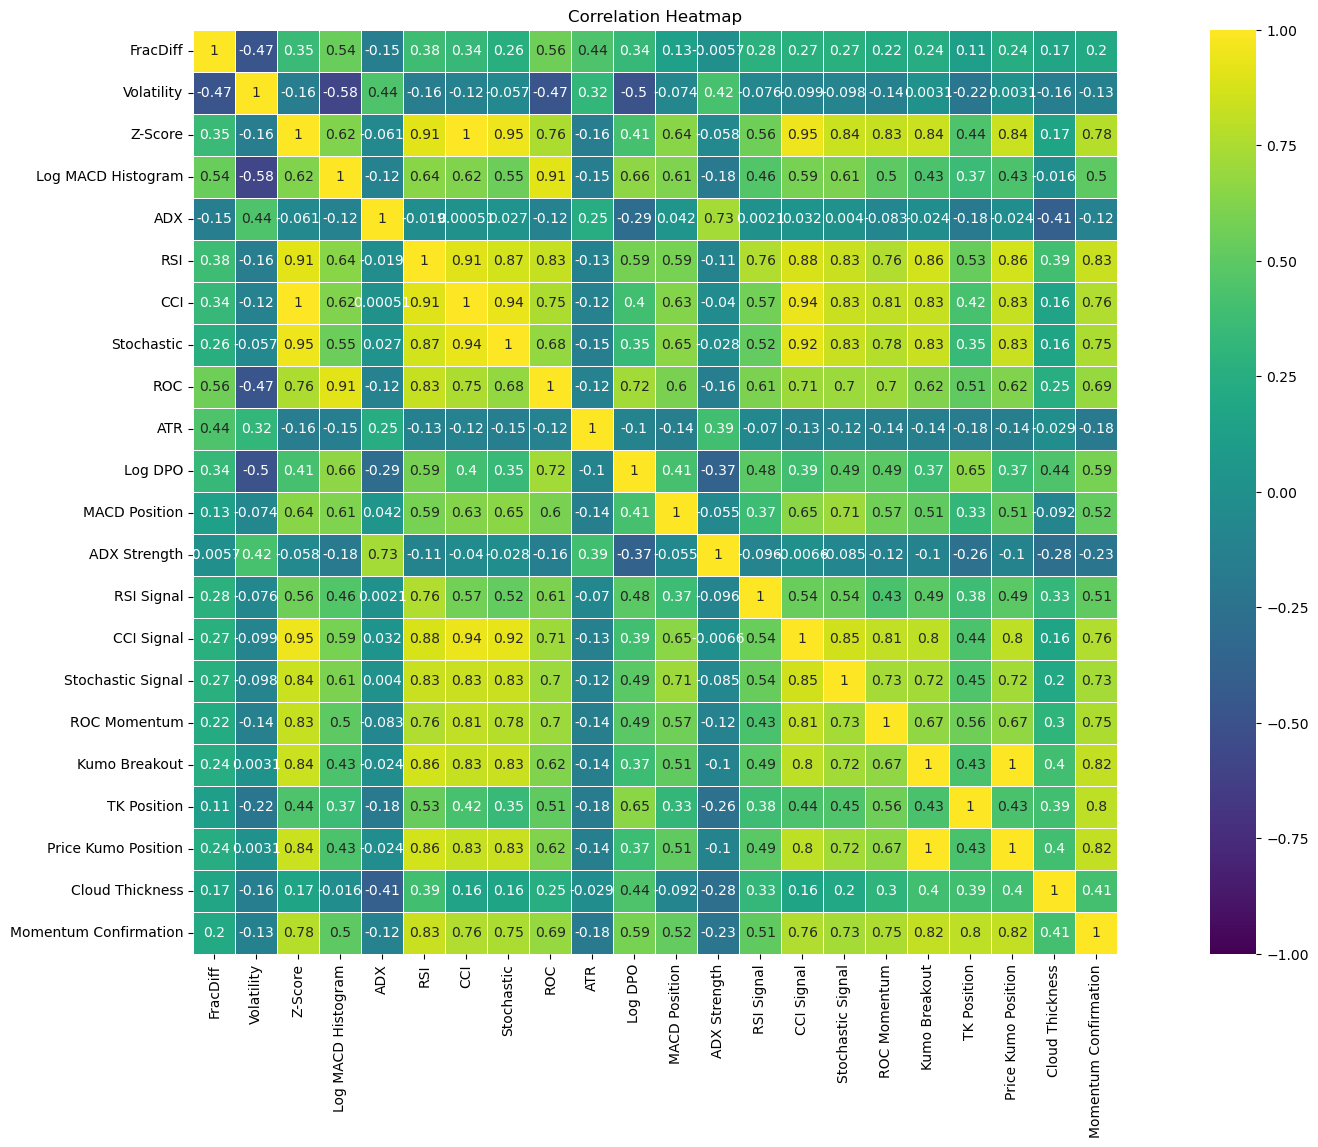

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(24, 12))

# Generate a heatmap of the correlation matrix
sns.heatmap(features.loc[moelcules].corr(), annot=True, cmap="viridis", vmin=-1, vmax=1, linewidths=.5, square=True)

# Show the plot
plt.title('Correlation Heatmap')
plt.show()

## CV

In [23]:
from typing import Dict, Union, Tuple, List, Any, Optional, Generator
import pandas as pd
import numpy as np
from abc import ABC, abstractmethod

class CrossValidator(ABC):
    """
    Abstract Base Class (ABC) for cross-validation strategies.
    Handles both single data inputs and dictionary inputs.

    :param data: The input data, either as a single DataFrame or a dictionary of DataFrames.
    :type data: Union[pd.DataFrame, Dict[str, pd.DataFrame]]

    :param labels: The labels corresponding to the data, either as a single Series or a dictionary of Series.
    :type labels: Optional[Union[pd.Series, Dict[str, pd.Series]]]

    :param groups: Optional group labels for stratified splitting.
    :type groups: Optional[np.ndarray]
    """


    @abstractmethod
    def get_n_splits(
        self,
        data: Optional[Union[pd.DataFrame, Dict[str, pd.DataFrame]]] = None,
        labels: Optional[Union[pd.Series, Dict[str, pd.Series]]] = None,
        groups: Optional[np.ndarray] = None
    ) -> int:
        """
        Return number of splits.

        :param data: Dataset or dictionary of datasets.
        :type data: Optional[Union[pd.DataFrame, Dict[str, pd.DataFrame]]]

        :param labels: Labels or dictionary of labels.
        :type labels: Optional[Union[pd.Series, Dict[str, pd.Series]]]

        :param groups: Group labels for the samples.
        :type groups: Optional[np.ndarray]

        :return: Number of splits.
        :rtype: int
        """


    @abstractmethod
    def _single_split(
        self,
        single_data: pd.DataFrame,
    ) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
        """
        Splits a single data set into train-test indices.

        This function provides train-test indices to split the data into train/test sets
        by respecting the time order (if applicable) and the specified number of splits.

        :param single_data: Input dataset.
        :type single_data: pd.DataFrame

        :return: Generator yielding train-test indices.
        :rtype: Generator[Tuple[np.ndarray, np.ndarray], None, None]
        """


    @abstractmethod
    def split(
        self,
        data: Union[pd.DataFrame, Dict[str, pd.DataFrame]],
        labels: Optional[Union[pd.Series, Dict[str, pd.Series]]] = None,
        groups: Optional[np.ndarray] = None
    ) -> Union[
        Generator[Tuple[np.ndarray, np.ndarray], None, None],
        Generator[Tuple[str, Tuple[np.ndarray, np.ndarray]], None, None]
    ]:
        """
        Splits data or a dictionary of data into train-test indices.

        This function returns a generator that yields train-test indices. If a dictionary
        of data is provided, the generator yields a key followed by the train-test indices.

        :param data: Dataset or dictionary of datasets.
        :type data: Union[pd.DataFrame, Dict[str, pd.DataFrame]]
        :param labels: Labels or dictionary of labels.
        :type labels: Optional[Union[pd.Series, Dict[str, pd.Series]]]
        :param groups: Group labels for the samples.
        :type groups: Optional[np.ndarray]

        :return: Generator yielding either train-test indices directly or a key
                followed by train-test indices.
        :rtype: Union[
            Generator[Tuple[np.ndarray, np.ndarray], None, None],
            Generator[Tuple[str, Tuple[np.ndarray, np.ndarray]], None, None]
        ]
        """


    @abstractmethod
    def _single_backtest_paths(
        self,
        single_data: pd.DataFrame
    ) -> Dict[str, List[Dict[str, List[np.ndarray]]]]:
        """
        Generates backtest paths for a single dataset.

        This function creates and returns backtest paths (i.e., combinations of training and test sets)
        for a single dataset by applying k-fold splitting or any other splitting strategy defined
        by the `_single_split` function.

        :param single_data: Input dataset.
        :type single_data: pd.DataFrame

        :return: Dictionary of backtest paths.
        :rtype: Dict[str, List[Dict[str, List[np.ndarray]]]]
        """


    @abstractmethod
    def backtest_paths(
        self,
        data: Union[pd.DataFrame, Dict[str, pd.DataFrame]],
    ) -> Union[
        Dict[str, List[Dict[str, np.ndarray]]],
        Dict[str, Dict[str, List[Dict[str, List[np.ndarray]]]]]
    ]:
        """
        Generates backtest paths for data.

        This function returns backtest paths for either a single dataset or a dictionary
        of datasets. Each backtest path consists of combinations of training and test sets.

        :param data: Dataset or dictionary of datasets.
        :type data: Union[pd.DataFrame, Dict[str, pd.DataFrame]]
        :param labels: Labels or dictionary of labels.
        :type labels: Union[pd.Series, Dict[str, pd.Series]]

        :return: Dictionary of backtest paths or dictionary of dictionaries for multiple datasets.
        :rtype: Union[
            Dict[str, List[Dict[str, np.ndarray]]],
            Dict[str, Dict[str, List[Dict[str, List[np.ndarray]]]]]
        ]
        """


    @abstractmethod
    def _single_backtest_predictions(
        self,
        single_estimator: Any,
        single_data: pd.DataFrame,
        single_labels: pd.Series,
        single_weights: Optional[np.ndarray] = None,
        n_jobs: int = 1
    ) -> Dict[str, np.ndarray]:
        """
        Obtain predictions for a single dataset during backtesting.

        This function leverages parallel computation to train and predict on different train-test splits
        of a single dataset using a given estimator. It utilizes the `_single_split` method to generate
        the train-test splits.

        :param single_estimator: Estimator or model to be trained and used for predictions.
        :type single_estimator: Any
        :param single_data: Data of the single dataset.
        :type single_data: pd.DataFrame
        :param single_labels: Labels corresponding to the single dataset.
        :type single_labels: pd.Series
        :param single_weights: Weights for the observations in the single dataset.
                            Defaults to equally weighted if not provided.
        :type single_weights: np.ndarray, optional
        :param n_jobs: The number of jobs to run in parallel. Default is 1.
        :type n_jobs: int, optional
        :return: Predictions structured in a dictionary for the backtest paths.
        :rtype: Dict[str, np.ndarray]
        """

    @abstractmethod
    def backtest_predictions(
        self,
        estimator: Union[Any, Dict[str, Any]],
        data: Union[pd.DataFrame, Dict[str, pd.DataFrame]],
        labels: Union[pd.Series, Dict[str, pd.Series]],
        sample_weights: Optional[Union[np.ndarray, Dict[str, np.ndarray]]] = None,
        predict_probability: bool = False,
        n_jobs: int = 1
    ) -> Union[Dict[str, np.ndarray], Dict[str, Dict[str, np.ndarray]]]:
        """
        Generate backtest predictions for single or multiple datasets.

        For each dataset, this function leverages the `_single_backtest_predictions` method to obtain
        predictions for different train-test splits using the given estimator.

        :param estimator: Model or estimator to be trained and used for predictions.
                        Can be a single estimator or a dictionary of estimators for multiple datasets.
        :type estimator: Union[Any, Dict[str, Any]]
        :param data: Input data for training and testing. Can be a single dataset or
                    a dictionary of datasets for multiple datasets.
        :type data: Union[pd.DataFrame, Dict[str, pd.DataFrame]]
        :param labels: Target labels for training and testing. Can be a single series or
                    a dictionary of series for multiple datasets.
        :type labels: Union[pd.Series, Dict[str, pd.Series]]
        :param sample_weights: Weights for the observations in the dataset(s).
                            Can be a single array or a dictionary of arrays for multiple datasets.
                            Defaults to None, which means equal weights for all observations.
        :type sample_weights: Optional[Union[np.ndarray, Dict[str, np.ndarray]]]
        :param n_jobs: The number of jobs to run in parallel. Default is 1.
        :type n_jobs: int, optional
        :return: Backtest predictions structured in a dictionary (or nested dictionaries for multiple datasets).
        :rtype: Union[Dict[str, np.ndarray], Dict[str, Dict[str, np.ndarray]]]
        """

In [24]:
from copy import deepcopy
from typing import (
    Any, Generator, List, Optional, Tuple, Union, Dict
)
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning

class KFold(CrossValidator):
    """
    K-Fold cross-validator.

    This class implements the K-Fold cross-validation strategy, where the dataset is
    divided into `k` consecutive folds. Each fold is then used once as a validation set
    while the `k - 1` remaining folds form the training set.
    """

    def __init__(
        self,
        n_splits: int,
        shuffle: bool = False,
        random_seed: int = None
    ) -> None:
        """
        Initialize the K-Fold cross-validator.

        :param n_splits: Number of splits or folds for the cross-validation.
                         The dataset will be divided into `n_splits` consecutive parts.
        :type n_splits: int
        :param shuffle: Whether to shuffle the data before splitting it into folds.
                        If `shuffle` is set to True, the data will be shuffled before splitting.
        :type shuffle: bool, optional
        :param random_seed: Seed used for random shuffling. Set this seed for reproducibility.
                            Only used when `shuffle` is True.
        :type random_seed: int, optional
        """
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_seed = random_seed

    def get_n_splits(
        self,
        data: Optional[Union[pd.DataFrame, Dict[str, pd.DataFrame]]] = None,
        labels: Optional[Union[pd.Series, Dict[str, pd.Series]]] = None,
        groups: Optional[np.ndarray] = None
    ) -> int:
        """
        Return number of splits.

        :param data: Dataset or dictionary of datasets.
        :type data: Union[pd.DataFrame, Dict[str, pd.DataFrame]]

        :param labels: Labels or dictionary of labels.
        :type labels: Optional[Union[pd.Series, Dict[str, pd.Series]]]

        :param groups: Group labels for the samples.
        :type groups: Optional[np.ndarray]

        :return: Number of splits.
        :rtype: int
        """
        return self.n_splits

    def _single_split(
        self,
        single_data: pd.DataFrame,
    ) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
        """
        Splits a single data set into train-test indices.

        This function provides train-test indices to split the data into train/test sets
        by respecting the time order (if applicable) and the specified number of splits.

        :param single_data: Input dataset.
        :type single_data: pd.DataFrame

        :return: Generator yielding train-test indices.
        :rtype: Generator[Tuple[np.ndarray, np.ndarray], None, None]
        """

        indices = np.arange(single_data.shape[0])
        if self.shuffle:
            np.random.seed(self.random_seed)
            np.random.shuffle(indices)

        for test_indices in np.array_split(indices, self.n_splits):
            train_indices = np.setdiff1d(indices, test_indices)

            yield train_indices, test_indices


    def split(
        self,
        data: Union[pd.DataFrame, Dict[str, pd.DataFrame]],
        labels: Optional[Union[pd.Series, Dict[str, pd.Series]]] = None,
        groups: Optional[np.ndarray] = None
    ) -> Union[
        Generator[Tuple[np.ndarray, np.ndarray], None, None],
        Generator[Tuple[str, Tuple[np.ndarray, np.ndarray]], None, None]
    ]:
        """
        Splits data or a dictionary of data into train-test indices.

        This function returns a generator that yields train-test indices. If a dictionary
        of data is provided, the generator yields a key followed by the train-test indices.

        :param data: Dataset or dictionary of datasets.
        :type data: Union[pd.DataFrame, Dict[str, pd.DataFrame]]
        :param labels: Labels or dictionary of labels.
        :type labels: Optional[Union[pd.Series, Dict[str, pd.Series]]]
        :param groups: Group labels for the samples.
        :type groups: Optional[np.ndarray]

        :return: Generator yielding either train-test indices directly or a key
                followed by train-test indices.
        :rtype: Union[
            Generator[Tuple[np.ndarray, np.ndarray], None, None],
            Generator[Tuple[str, Tuple[np.ndarray, np.ndarray]], None, None]
        ]
        """

        if isinstance(data, dict):
            for key in data:
                for train_indices, test_indices in self._single_split(data[key]):
                    yield key, (train_indices, test_indices)
        else:
            for train_indices, test_indices in self._single_split(data):
                yield train_indices, test_indices

    def _single_backtest_paths(
        self,
        single_data: pd.DataFrame
    ) -> Dict[str, List[Dict[str, List[np.ndarray]]]]:
        """
        Generates backtest paths for a single dataset.

        This function creates and returns backtest paths (i.e., combinations of training and test sets)
        for a single dataset by applying k-fold splitting or any other splitting strategy defined
        by the `_single_split` function.

        :param single_data: Input dataset.
        :type single_data: pd.DataFrame

        :return: Dictionary of backtest paths.
        :rtype: Dict[str, List[Dict[str, List[np.ndarray]]]]
        """

        path_data = []
        paths = {}

        for train_indices, test_indices in self._single_split(single_data):
            path_data.append({
                "Train": np.array(train_indices),
                "Test": test_indices,
            })

        paths['Path 1'] = path_data

        return paths

    def backtest_paths(
        self,
        data: Union[pd.DataFrame, Dict[str, pd.DataFrame]],
    ) -> Union[
        Dict[str, List[Dict[str, np.ndarray]]],
        Dict[str, Dict[str, List[Dict[str, List[np.ndarray]]]]]
    ]:
        """
        Generates backtest paths for data.

        This function returns backtest paths for either a single dataset or a dictionary
        of datasets. Each backtest path consists of combinations of training and test sets.

        :param data: Dataset or dictionary of datasets.
        :type data: Union[pd.DataFrame, Dict[str, pd.DataFrame]]

        :return: Dictionary of backtest paths or dictionary of dictionaries for multiple datasets.
        :rtype: Union[
            Dict[str, List[Dict[str, np.ndarray]]],
            Dict[str, Dict[str, List[Dict[str, List[np.ndarray]]]]]
        ]
        """

        if isinstance(data, dict):
            multiple_paths = {}
            for key in data:
                multiple_paths[key] = self._single_backtest_paths(data[key])

            return multiple_paths
        else:

            return self._single_backtest_paths(data)

    def _single_backtest_predictions(
        self,
        single_estimator: Any,
        single_data: pd.DataFrame,
        single_labels: pd.Series,
        single_weights: Optional[np.ndarray] = None,
        predict_probability: bool = False,
        n_jobs: int = 1
    ) -> Dict[str, np.ndarray]:
        """
        Obtain predictions for a single dataset during backtesting.

        This function leverages parallel computation to train and predict on different train-test splits
        of a single dataset using a given estimator. It utilizes the `_single_split` method to generate
        the train-test splits.

        :param single_estimator: Estimator or model to be trained and used for predictions.
        :type single_estimator: Any
        :param single_data: Data of the single dataset.
        :type single_data: pd.DataFrame
        :param single_labels: Labels corresponding to the single dataset.
        :type single_labels: pd.Series
        :param single_weights: Weights for the observations in the single dataset.
                            Defaults to equally weighted if not provided.
        :type single_weights: np.ndarray, optional
        :param predict_probability: If True, predict the probability of forecasts.
        :type predict_probability: bool
        :param n_jobs: The number of jobs to run in parallel. Default is 1.
        :type n_jobs: int, optional
        :return: Predictions structured in a dictionary for the backtest paths.
        :rtype: Dict[str, np.ndarray]
        """

        if single_weights is None:
            single_weights = np.ones(len(single_data))

        def train_test_single_estimator(
            single_estimator_: Any,
            train_indices: np.ndarray,
            test_indices: np.ndarray
        ) -> np.ndarray:
            X_train = single_data.iloc[train_indices]
            y_train = single_labels.iloc[train_indices]
            weights_train = single_weights[train_indices]

            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=ConvergenceWarning)
                try:
                    single_estimator_.fit(X_train, y_train, sample_weight=weights_train)

                except TypeError:
                    single_estimator_.fit(X_train, y_train)

            X_test = single_data.iloc[test_indices]

            if predict_probability:
                return single_estimator_.predict_proba(X_test)

            else:
                return single_estimator_.predict(X_test)

        path_data = Parallel(n_jobs=n_jobs)(
            delayed(train_test_single_estimator)(
                deepcopy(single_estimator), train_indices, test_indices
            ) for train_indices, test_indices in self._single_split(single_data)
        )

        paths_predictions = {'Path 1': np.concatenate(path_data)}

        return paths_predictions


    def backtest_predictions(
        self,
        estimator: Union[Any, Dict[str, Any]],
        data: Union[pd.DataFrame, Dict[str, pd.DataFrame]],
        labels: Union[pd.Series, Dict[str, pd.Series]],
        sample_weights: Optional[Union[np.ndarray, Dict[str, np.ndarray]]] = None,
        predict_probability: bool = False,
        n_jobs: int = 1
    ) -> Union[Dict[str, np.ndarray], Dict[str, Dict[str, np.ndarray]]]:
        """
        Generate backtest predictions for single or multiple datasets.

        For each dataset, this function leverages the `_single_backtest_predictions` method to obtain
        predictions for different train-test splits using the given estimator.

        :param estimator: Model or estimator to be trained and used for predictions.
                        Can be a single estimator or a dictionary of estimators for multiple datasets.
        :type estimator: Union[Any, Dict[str, Any]]
        :param data: Input data for training and testing. Can be a single dataset or
                    a dictionary of datasets for multiple datasets.
        :type data: Union[pd.DataFrame, Dict[str, pd.DataFrame]]
        :param labels: Target labels for training and testing. Can be a single series or
                    a dictionary of series for multiple datasets.
        :type labels: Union[pd.Series, Dict[str, pd.Series]]
        :param sample_weights: Weights for the observations in the dataset(s).
                            Can be a single array or a dictionary of arrays for multiple datasets.
                            Defaults to None, which means equal weights for all observations.
        :type sample_weights: Optional[Union[np.ndarray, Dict[str, np.ndarray]]]
        :param predict_probability: If True, predict the probability of forecasts.
        :type predict_probability: bool
        :param n_jobs: The number of jobs to run in parallel. Default is 1.
        :type n_jobs: int, optional

        :return: Backtest predictions structured in a dictionary (or nested dictionaries for multiple datasets).
        :rtype: Union[Dict[str, np.ndarray], Dict[str, Dict[str, np.ndarray]]]
        """

        if isinstance(data, dict):
            multiple_paths_predictions = {}
            for key in data:
                multiple_paths_predictions[key] = self._single_backtest_predictions(
                    estimator[key], data[key], labels[key],
                    sample_weights[key] if sample_weights else None, predict_probability, n_jobs
                )
            return multiple_paths_predictions

        return self._single_backtest_predictions(
            estimator, data, labels, sample_weights, predict_probability, n_jobs
        )

In [25]:
from copy import deepcopy
from typing import (
    Any, Generator, Optional, Tuple, Dict
)
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning

class WalkForward(KFold):
    """
    WalkForward Cross-Validator for Time Series Data.

    This cross-validator provides train/test indices meant to split time series data 
    in a "walk-forward" manner, which is suitable for time series forecasting tasks. 
    In each split, the training set progressively grows in size (subject to the optional
    maximum size constraint) while the test set remains roughly constant in size. 
    A gap can be optionally introduced between the training and test set to simulate 
    forecasting on unseen future data after a certain interval.

    The WalkForward cross-validator is inherently different from traditional K-Fold
    cross-validation which shuffles and splits the dataset into train/test without 
    considering the time order. In time series tasks, ensuring that the model is 
    trained on past data and validated on future data is crucial. This cross-validator 
    achieves that by progressively walking forward in time through the dataset.
    """

    def __init__(
        self,
        n_splits: int = 5,
        max_train_size: int = None,
        gap: int = 0
    ) -> None:
        """
        Initialize the TimeSeriesWalkForward cross-validator.

        Parameters:
        -----------
        n_splits : int, default=5
            Number of splits/folds. Must be at least 2.
        
        max_train_size : int, optional
            Maximum number of observations allowed in the training dataset.
            If provided, the most recent `max_train_size` observations are used 
            for training.

        gap : int, default=0
            Number of observations to skip between the end of the training data 
            and the start of the test data. Useful for simulating forecasting 
            scenarios where the test data is not immediately after the training data.
        """
        super().__init__(n_splits=n_splits)  # Initializing the parent class with n_splits
        self.max_train_size = max_train_size
        self.gap = gap


    def _single_split(
        self,
        single_data: pd.DataFrame,
    ) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
        """
        Splits a single data set into train-test indices.

        This function provides train-test indices to split the data into train/test sets
        by respecting the time order (if applicable) and the specified number of splits.

        :param single_data: Input dataset.
        :type single_data: pd.DataFrame

        :return: Generator yielding train-test indices.
        :rtype: Generator[Tuple[np.ndarray, np.ndarray], None, None]
        """

        indices = np.arange(single_data.shape[0])
        gap = self.gap
        max_train_size = self.max_train_size

        for test_indices in np.array_split(indices, self.n_splits):
            # Ensure that train indices come before test indices
            last_test_index = test_indices[-1]
            train_indices = np.setdiff1d(indices, test_indices)
            train_indices = train_indices[train_indices < last_test_index]
            
            # Exclude gap from the end of train set
            if self.gap:
                train_indices = train_indices[:-gap]
            
            # Ensuring the training set does not exceed max_train_size
            if self.max_train_size and len(train_indices) > max_train_size:
                train_indices = train_indices[-max_train_size:]
            
            yield train_indices, test_indices    


    def _single_backtest_predictions(
        self,
        single_estimator: Any,
        single_data: pd.DataFrame,
        single_labels: pd.Series,
        single_weights: Optional[np.ndarray] = None,
        predict_probability: bool = False,
        n_jobs: int = 1
    ) -> Dict[str, np.ndarray]:
        """
        Obtain predictions for a single dataset during backtesting.

        This function leverages parallel computation to train and predict on different train-test splits
        of a single dataset using a given estimator. It utilizes the `_single_split` method to generate
        the train-test splits.

        :param single_estimator: Estimator or model to be trained and used for predictions.
        :type single_estimator: Any
        :param single_data: Data of the single dataset.
        :type single_data: pd.DataFrame
        :param single_labels: Labels corresponding to the single dataset.
        :type single_labels: pd.Series
        :param single_weights: Weights for the observations in the single dataset.
                            Defaults to equally weighted if not provided.
        :type single_weights: np.ndarray, optional
        :param predict_probability: If True, predict the probability of forecasts.
        :type predict_probability: bool
        :param n_jobs: The number of jobs to run in parallel. Default is 1.
        :type n_jobs: int, optional
        :return: Predictions structured in a dictionary for the backtest paths.
        :rtype: Dict[str, np.ndarray]
        """

        if single_weights is None:
            single_weights = np.ones(len(single_data))

        def train_test_single_estimator(
            single_estimator_: Any,
            train_indices: np.ndarray,
            test_indices: np.ndarray
        ) -> np.ndarray:
            
            if len(train_indices) == 0:
                if predict_probability:
                    n_columns = len(np.unique(single_labels)) if predict_probability else 1
                    return np.full((len(test_indices), n_columns), np.nan)
        
                else:
                    return np.full(len(test_indices), np.nan)
            
            X_train = single_data.iloc[train_indices]
            y_train = single_labels.iloc[train_indices]
            weights_train = single_weights[train_indices]

            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=ConvergenceWarning)
                try:
                    single_estimator_.fit(X_train, y_train, sample_weight=weights_train)

                except TypeError:
                    single_estimator_.fit(X_train, y_train)

            X_test = single_data.iloc[test_indices]

            if predict_probability:
                return single_estimator_.predict_proba(X_test)

            else:
                return single_estimator_.predict(X_test)

        path_data = Parallel(n_jobs=n_jobs)(
            delayed(train_test_single_estimator)(
                deepcopy(single_estimator), train_indices, test_indices
            ) for train_indices, test_indices in self._single_split(single_data)
        )

        paths_predictions = {'Path 1': np.concatenate(path_data)}

        return paths_predictions        

In [26]:
from copy import deepcopy
from typing import Generator, Optional, Tuple, Union, Dict, List, Any, Set
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import warnings
from sklearn.exceptions import ConvergenceWarning

class PurgedKFold(CrossValidator):

    @staticmethod
    def filtered_training_indices_with_embargo(
        data_info_range: pd.Series,
        test_time_range: pd.Series,
        embargo_fraction: float = 0,
        continous_test_times: bool = False,
    ) -> pd.Series:
        """
        Purge observations in the training set with embargo.

        Finds the training set indices based on the information on each record
        and the test set range. It purges the training set of observations that
        overlap with the test set in the time dimension and adds an embargo period
        to further prevent potential information leakage.

        .. math::
            \text{embargo\_length} = \text{len(data\_info\_range)} \times \text{embargo\_fraction}

        :param data_info_range: Series detailing the information range for each record.
            - *data_info_range.index*: Time when the information extraction started.
            - *data_info_range.value*: Time when the information extraction ended.
        :type data_info_range: pd.Series
        :param test_time_range: Series containing times for the test dataset.
        :type test_time_range: pd.Series
        :param embargo_fraction: Fraction of the dataset trailing the test observations to exclude from training.
        :type embargo_fraction: float
        :param continuous_test_times: If set to True, considers the test time range as continuous.
        :type continuous_test_times: bool

        :return: Series of filtered training data after applying embargo.
        :rtype: pd.Series
        """

        indices_to_drop: Set[int] = set()
        embargo_length = int(len(data_info_range) * embargo_fraction)

        effective_test_time_range = test_time_range if not continous_test_times else pd.Series(test_time_range.iloc[-1], index=[test_time_range.index[0]])

        if embargo_length == 0:
            embargoed_data_info_range = pd.Series(test_time_range.values, index=test_time_range.values)

        else:
            effective_sample = data_info_range.loc[test_time_range.index.min():].copy().drop_duplicates()
            embargoed_data_info_range = pd.Series(effective_sample.values, index=effective_sample.values)
            embargoed_data_info_range = embargoed_data_info_range.shift(-embargo_length).fillna(embargoed_data_info_range.values[-1]) 

        for start_ix, end_ix in effective_test_time_range.items():
            # Adding the embargo period
            end_ix_embargoed = embargoed_data_info_range.loc[end_ix]

            overlapping_start = data_info_range[
                (start_ix <= data_info_range.index) & (data_info_range.index <= end_ix_embargoed)
            ].index

            overlapping_end = data_info_range[
                (start_ix <= data_info_range) & (data_info_range <= end_ix_embargoed)
            ].index

            enveloping = data_info_range[
                (data_info_range.index <= start_ix) & (end_ix_embargoed <= data_info_range)
            ].index

            indices_to_drop.update(overlapping_start)
            indices_to_drop.update(overlapping_end)
            indices_to_drop.update(enveloping)

        return data_info_range.drop(indices_to_drop)


    def __init__(
            self,
            n_splits: int,
            times: Union[pd.Series, Dict[str, pd.Series]],
            embargo: float = 0,
    ) -> None:
        """
        Purged k-fold cross-validation to prevent information leakage.

        Implements a cross-validation strategy where each fold is purged
        of observations overlapping with the training set in the time dimension.
        An embargo period is also introduced to further prevent potential
        information leakage.

        Attributes:
            n_splits (int): Number of splits/folds.
            times (Union[pd.Series, Dict[str, pd.Series]]): Series or dict containing time data.
            embargo (float): The embargo period.
            is_multiple_datasets (bool): True if `times` is a dict, else False.

        :param n_splits: Number of splits or folds.
        :type n_splits: int

        :param times: Series detailing the information range for each record.
            - *times.index*: Time when the information extraction started.
            - *times.value*: Time when the information extraction ended.
        :type times: pd.Series

        :param embargo: The embargo period to further prevent potential
                        information leakage.
        :type embargo: float
        """
        self.n_splits = n_splits
        self.times = times
        self.embargo = embargo
        self.is_multiple_datasets = isinstance(times, dict)


    def get_n_splits(
        self,
        data: Optional[Union[pd.DataFrame, Dict[str, pd.DataFrame]]] = None,
        labels: Optional[Union[pd.Series, Dict[str, pd.Series]]] = None,
        groups: Optional[np.ndarray] = None
    ) -> int:
        """
        Return number of splits.

        :param data: Dataset or dictionary of datasets.
        :type data: Optional[Union[pd.DataFrame, Dict[str, pd.DataFrame]]]

        :param labels: Labels or dictionary of labels.
        :type labels: Optional[Union[pd.Series, Dict[str, pd.Series]]]

        :param groups: Group labels for the samples.
        :type groups: Optional[np.ndarray]

        :return: Number of splits.
        :rtype: int
        """
        return self.n_splits


    def _validate_input(
        self,
        single_times: pd.Series,
        single_data: pd.DataFrame
    ) -> None:
        """
        Validate that the input data and times share the same index.

        This function checks if the provided data and its corresponding times
        have the same index. If they do not match, it raises a `ValueError`.

        :param single_times: Time series data to be validated.
        :type single_times: pd.Series
        :param single_data: Dataset with which the times should align.
        :type single_data: pd.DataFrame
        :raises ValueError: If the indices of the data and times do not match.
        :return: None
        """
        if not single_data.index.equals(single_times.index):
            raise ValueError('Data and through date values must have the same index')


    def _get_train_indices(
        self,
        test_indices: np.ndarray,
        single_times: pd.Series,
        continous_test_times: bool = False,
    ) -> np.ndarray:
        """
        Obtain the training indices considering purging and embargo.

        This function retrieves the training set indices based on the given test indices
        while considering the purging and embargo strategy.

        :param test_indices: Indices used for the test set.
        :type test_indices: np.ndarray
        :param single_times: Time series data used for purging and embargo.
        :type single_times: pd.Series
        :return: Training indices after applying purging and embargo.
        :rtype: np.ndarray
        """
        test_time_range = single_times.iloc[test_indices]
        train_times = self.filtered_training_indices_with_embargo(
            single_times, test_time_range, self.embargo, continous_test_times
        )
        return pd.Series(train_times.index).map(single_times.index.get_loc).tolist()


    def _single_split(
        self,
        single_times: pd.Series,
        single_data: pd.DataFrame,
    ) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
        """
        Split the data into train and test sets.

        This function splits the data for a single dataset considering purging and embargo.

        :param single_times: Time series data used for purging and embargo.
        :type single_times: pd.Series
        :param single_data: Dataset to split.
        :type single_data: pd.DataFrame
        :return: Train and test indices.
        :rtype: Generator[Tuple[np.ndarray, np.ndarray], None, None]
        """
        self._validate_input(single_times, single_data)

        indices = np.arange(len(single_data))

        for test_indices in np.array_split(indices, self.n_splits):
            train_indices = self._get_train_indices(test_indices, single_times, True)
            yield train_indices, test_indices


    def split(
        self,
        data: Union[pd.DataFrame, Dict[str, pd.DataFrame]],
        labels: Optional[Union[pd.Series, Dict[str, pd.Series]]] = None,
        groups: Optional[np.ndarray] = None
    ) -> Union[
        Generator[Tuple[np.ndarray, np.ndarray], None, None],
        Generator[Tuple[str, Tuple[np.ndarray, np.ndarray]], None, None]
    ]:
        """
        Split multiple datasets into train and test sets.

        This function either splits a single dataset or multiple datasets considering
        purging and embargo.

        :param data: Dataset or dictionary of datasets.
        :type data: Union[pd.DataFrame, Dict[str, pd.DataFrame]]
        :param labels: Labels corresponding to the datasets, if available.
        :type labels: Optional[Union[pd.Series, Dict[str, pd.Series]]]
        :param groups: Group information, if available.
        :type groups: Optional[np.ndarray]
        :return: Train and test indices or key with train and test indices for multiple datasets.
        :rtype: Union[Generator[Tuple[np.ndarray, np.ndarray], None, None],
                    Generator[Tuple[str, Tuple[np.ndarray, np.ndarray]], None, None]]
        """
        if self.is_multiple_datasets:
            for key in self.times:
                for train_indices, test_indices in self._single_split(
                    self.times[key], data[key]
                ):
                    yield key, (train_indices, test_indices)
        else:
            for train_indices, test_indices in self._single_split(
                self.times, data
            ):
                yield train_indices, test_indices


    def _single_backtest_paths(
        self,
        single_times: pd.Series,
        single_data: pd.DataFrame,
    ) -> Dict[str, List[Dict[str, np.ndarray]]]:
        """
        Generate backtest paths based on training and testing indices.

        This function first validates the input data and times. Then, it generates
        the training and testing indices for backtesting. These paths are organized
        into a dictionary with a designated name for each backtest path.

        :param single_times: Time series data for validation.
        :type single_times: pd.Series
        :param single_data: Dataset with which the times should align.
        :type single_data: pd.DataFrame
        :return: Dictionary containing the backtest paths with training and testing indices.
        :rtype: Dict[str, List[Dict[str, np.ndarray]]]
        """
        self._validate_input(single_times, single_data)

        path_data = []
        paths = {}

        for train_indices, test_indices in self._single_split(single_times, single_data):
            path_data.append({
                "Train": np.array(train_indices),
                "Test": test_indices,
            })

        paths['Path 1'] = path_data

        return paths


    def backtest_paths(
        self,
        data: Union[pd.DataFrame, Dict[str, pd.DataFrame]],
    ) -> Union[
        Dict[str, List[Dict[str, np.ndarray]]],
        Dict[str, Dict[str, List[Dict[str, List[np.ndarray]]]]]
    ]:
        """
        Generate backtest paths for single or multiple datasets.

        This function checks whether multiple datasets are being used. If so, it iterates through each
        dataset, generating backtest paths using the `_single_backtest_paths` method. Otherwise, it directly
        returns the backtest paths for the single dataset.

        :param data: Input data on which the backtest paths are based.
                    Can be either a single DataFrame or a dictionary of DataFrames for multiple datasets.
        :type data: Union[pd.DataFrame, Dict[str, pd.DataFrame]]

        :return: A dictionary where each key is a backtest path name, and the value is
                a list of dictionaries with train and test index arrays. For multiple datasets,
                a nested dictionary structure is returned.
        :rtype: Union[
            Dict[str, List[Dict[str, np.ndarray]]],
            Dict[str, Dict[str, List[Dict[str, List[np.ndarray]]]]]
        ]

        """
        if self.is_multiple_datasets:
            multiple_paths = {}
            for key in self.times:
                multiple_paths[key] = self._single_backtest_paths(self.times[key], data[key])

            return multiple_paths
        else:

            return self._single_backtest_paths(self.times, data)


    def _single_backtest_predictions(
        self,
        single_estimator: Any,
        single_times: pd.Series,
        single_data: pd.DataFrame,
        single_labels: pd.Series,
        single_weights: Optional[np.ndarray] = None,
        predict_probability: bool = False,
        n_jobs: int = 1
    ) -> Dict[str, np.ndarray]:
        """
        Obtain predictions for a single dataset during backtesting.

        This function leverages parallel computation to train and predict on different train-test splits
        of a single dataset using a given estimator. It utilizes the `_single_split` method to generate
        the train-test splits.

        :param single_estimator: Estimator or model to be trained and used for predictions.
        :type single_estimator: Any
        :param single_times: Timestamps for the single dataset.
        :type single_times: pd.Series
        :param single_data: Data of the single dataset.
        :type single_data: pd.DataFrame
        :param single_labels: Labels corresponding to the single dataset.
        :type single_labels: pd.Series
        :param single_weights: Weights for the observations in the single dataset.
                            Defaults to equally weighted if not provided.
        :type single_weights: np.ndarray, optional
        :param predict_probability: If True, predict the probability of forecasts.
        :type predict_probability: bool
        :param n_jobs: The number of jobs to run in parallel. Default is 1.
        :type n_jobs: int, optional
        :return: Predictions structured in a dictionary for the backtest paths.
        :rtype: Dict[str, np.ndarray]
        """
        self._validate_input(single_times, single_data)

        if single_weights is None:
            single_weights = np.ones(len(single_data))

        def train_test_single_estimator(
            single_estimator_: Any,
            train_indices: np.ndarray,
            test_indices: np.ndarray
        ) -> np.ndarray:
            X_train = single_data.iloc[train_indices]
            y_train = single_labels.iloc[train_indices]
            weights_train = single_weights[train_indices]

            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=ConvergenceWarning)
                try:
                    single_estimator_.fit(X_train, y_train, sample_weight=weights_train)

                except TypeError:
                    single_estimator_.fit(X_train, y_train)

            X_test = single_data.iloc[test_indices]

            if predict_probability:
                return single_estimator_.predict_proba(X_test)

            else:
                return single_estimator_.predict(X_test)

        path_data = Parallel(n_jobs=n_jobs)(
            delayed(train_test_single_estimator)(
                deepcopy(single_estimator), train_indices, test_indices
            ) for train_indices, test_indices in self._single_split(single_times, single_data)
        )

        paths_predictions = {'Path 1': np.concatenate(path_data)}

        return paths_predictions


    def backtest_predictions(
        self,
        estimator: Union[Any, Dict[str, Any]],
        data: Union[pd.DataFrame, Dict[str, pd.DataFrame]],
        labels: Union[pd.Series, Dict[str, pd.Series]],
        sample_weights: Optional[Union[np.ndarray, Dict[str, np.ndarray]]] = None,
        predict_probability: bool = False,
        n_jobs: int = 1
    ) -> Union[Dict[str, np.ndarray], Dict[str, Dict[str, np.ndarray]]]:
        """
        Generate backtest predictions for single or multiple datasets.

        For each dataset, this function leverages the `_single_backtest_predictions` method to obtain
        predictions for different train-test splits using the given estimator.

        :param estimator: Model or estimator to be trained and used for predictions.
                        Can be a single estimator or a dictionary of estimators for multiple datasets.
        :type estimator: Union[Any, Dict[str, Any]]
        :param data: Input data for training and testing. Can be a single dataset or
                    a dictionary of datasets for multiple datasets.
        :type data: Union[pd.DataFrame, Dict[str, pd.DataFrame]]
        :param labels: Target labels for training and testing. Can be a single series or
                    a dictionary of series for multiple datasets.
        :type labels: Union[pd.Series, Dict[str, pd.Series]]
        :param sample_weights: Weights for the observations in the dataset(s).
                            Can be a single array or a dictionary of arrays for multiple datasets.
                            Defaults to None, which means equal weights for all observations.
        :type sample_weights: Optional[Union[np.ndarray, Dict[str, np.ndarray]]]
        :param predict_probability: If True, predict the probability of forecasts.
        :type predict_probability: bool
        :param n_jobs: The number of jobs to run in parallel. Default is 1.
        :type n_jobs: int, optional
        :return: Backtest predictions structured in a dictionary (or nested dictionaries for multiple datasets).
        :rtype: Union[Dict[str, np.ndarray], Dict[str, Dict[str, np.ndarray]]]
        """

        if self.is_multiple_datasets:
            multiple_paths_predictions = {}
            for key in self.times:
                multiple_paths_predictions[key] = self._single_backtest_predictions(
                    estimator[key], self.times[key], data[key], labels[key],
                    sample_weights[key] if sample_weights else None, predict_probability, n_jobs
                )
            return multiple_paths_predictions

        return self._single_backtest_predictions(
            estimator, self.times, data, labels, sample_weights, predict_probability, n_jobs
        )

In [27]:
from copy import deepcopy
from typing import Generator, Optional, Tuple, Union, Dict, List, Any
from itertools import combinations
import pandas as pd
import numpy as np
from collections import ChainMap, defaultdict
from joblib import Parallel, delayed
from math import comb
import warnings
from sklearn.exceptions import ConvergenceWarning

class CombinatorialPurged(PurgedKFold):
    """
    Combinatorial Purged Cross-Validation (CPCV) implementation based on Marcos Lopez de Prado's method.

    This class provides a cross-validation scheme that aims to address the main drawback of the Walk Forward
    and traditional Cross-Validation methods by testing multiple paths. Given a number of backtest paths,
    CPCV generates the precise number of combinations of training/testing sets needed to generate those paths,
    while purging training observations that might contain leaked information.

    Parameters
    ----------
    n_splits : int
        Number of splits/groups to partition the data into.
    n_test_groups : int
        Size of the testing set in terms of groups.
    times : Union[pd.Series, Dict[str, pd.Series]]
        The timestamp series associated with the labels.
    embargo : float
        The embargo rate for purging.
    """


    @staticmethod
    def _path_locations(
        n_splits: int,
        combinations_: List[Tuple[int]]
    ) -> Dict[int, List[Tuple[int, int]]]:
        """
        Generate a labeled path matrix and return path locations for N choose K.

        This method generates a matrix where each entry corresponds to a specific combination of
        training/testing sets, and helps in mapping these combinations to specific backtest paths.

        Parameters
        ----------
        n_splits : int
            Number of splits/groups to partition the data into.
        combinations_ : list
            List of combinations for training/testing sets.

        Returns
        -------
        dict
            A dictionary mapping each backtest path to its corresponding train/test combination.
        """

        # Initialize a zero matrix
        matrix = np.zeros((n_splits, len(combinations_)), dtype=int)

        # Set appropriate entries to 1 and label path numbers in the same loop
        for col, indices in enumerate(combinations_):
            matrix[indices, col] = 1

        # Label path numbers
        def label_path(row):
            counter = iter(range(1, row.sum() + 1))
            return [next(counter) if x == 1 else 0 for x in row]

        path_numbers = np.array(list(map(label_path, matrix)))

        # Extract path locations using loops
        def map_to_location(coord):
            i, j = coord
            value = path_numbers[i, j]
            locations[value].append((i, j))

        rows, cols = path_numbers.shape
        locations = defaultdict(list)
        list(map(map_to_location, [(x, y) for x in range(rows) for y in range(cols) if path_numbers[x, y] != 0]))

        return dict(locations)


    @staticmethod
    def _combinatorial_splits(
        combinations_: List[Tuple[int]],
        split_segments: np.ndarray
    ) -> Generator[np.ndarray, None, None]:
        """
        Generate combinatorial test sets based on the number of test groups (n_test_groups).

        This method creates test sets by considering all possible combinations of group splits, allowing
        for the creation of multiple test paths, as described in the CPCV methodology.

        Parameters
        ----------
        combinations_ : list
            List of combinations for training/testing sets.
        split_segments : np.ndarray
            Array of data split segments.

        Returns
        -------
        Generator[np.ndarray]
            A generator yielding the combinatorial test sets.
        """

        for test_groups in combinations_:
            test_sets = [split for i, split in enumerate(split_segments) if i in test_groups]
            yield np.concatenate(test_sets)


    def __init__(
        self,
        n_splits: int,
        n_test_groups: int,
        times: Union[pd.Series, Dict[str, pd.Series]],
        embargo: float = 0
    ):
        """
        Initialize the CombinatorialPurged class.

        Parameters
        ----------
        n_splits : int
            Number of splits/groups to partition the data into.
        n_test_groups : int
            Size of the testing set in terms of groups.
        times : Union[pd.Series, Dict[str, pd.Series]]
            The timestamp series associated with the labels.
        embargo : float
            The embargo rate for purging.
        """

        super().__init__(n_splits, times, embargo)
        self.n_test_groups = n_test_groups

    def get_n_splits(
        self,
        data: Optional[Union[pd.DataFrame, Dict[str, pd.DataFrame]]] = None,
        labels: Optional[Union[pd.Series, Dict[str, pd.Series]]] = None,
        groups: Optional[np.ndarray] = None
    ) -> int:
        """
        Return number of splits.

        :param data: Dataset or dictionary of datasets.
        :type data: Optional[Union[pd.DataFrame, Dict[str, pd.DataFrame]]]

        :param labels: Labels or dictionary of labels.
        :type labels: Optional[Union[pd.Series, Dict[str, pd.Series]]]

        :param groups: Group labels for the samples.
        :type groups: Optional[np.ndarray]

        :return: Number of splits.
        :rtype: int
        """
        return comb(self.n_splits, self.n_test_groups)

    def _single_split(
        self,
        single_times: np.ndarray,
        single_data: np.ndarray,
    ) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
        """
        Splits data into train and test indices based on the defined combinatorial splits.

        This function is used to generate multiple train-test splits based on the combinatorial
        cross-validation method. It ensures that each train-test split is properly purged and
        embargoed to prevent data leakage.

        :param single_times: Timestamp series associated with the labels.
        :param single_data: The input data to be split.

        :return: Generator that yields tuples of (train indices, test indices).

        .. note:: The function validates the input, and uses combinatorial cross-validation method to
                produce the train-test splits.
        """

        self._validate_input(single_times, single_data)

        indices = np.arange(single_data.shape[0])
        split_segments = np.array_split(indices, self.n_splits)
        combinations_ = list(combinations(range(self.n_splits), self.n_test_groups))

        all_combinatorial_splits = list(
            CombinatorialPurged._combinatorial_splits(combinations_, split_segments)
        )

        for test_indices in all_combinatorial_splits:
            train_indices = self._get_train_indices(test_indices, single_times)
            yield train_indices, test_indices


    def _combinations_and_path_locations_and_split_segments(
        self,
        data: pd.DataFrame
    ) -> Tuple[List[Tuple[int, ...]], Dict[str, np.ndarray], List[np.ndarray]]:
        """
        Generate combinations, path locations, and split segments for the data.

        This function is a helper that computes necessary components for combinatorial cross-validation.

        :param data: The input dataframe to generate combinations, path locations, and split segments.

        :return: Tuple containing combinations, path locations, and split segments.

        .. math::
        \\text{combinations} = \\binom{n}{k}
        """

        combinations_ = list(combinations(range(self.n_splits), self.n_test_groups))
        locations = CombinatorialPurged._path_locations(self.n_splits, combinations_)

        indices = np.arange(data.shape[0])
        split_segments = np.array_split(indices, self.n_splits)

        return combinations_, locations, split_segments


    def _single_backtest_paths(
            self,
            single_times: pd.Series,
            single_data: pd.DataFrame,
    ) -> Dict[str, List[Dict[str, List[np.ndarray]]]]:
        """
        Generate the backtest paths for given input data.

        This function creates multiple backtest paths based on combinatorial splits, where
        each path represents a sequence of train-test splits. It ensures that data leakage
        is prevented by purging and applying embargo to the train-test splits.

        :param single_times: Timestamp series associated with the data.
        :param single_data: Input data on which the backtest paths are based.

        :return: A dictionary where each key is a backtest path name, and the value is
                a list of dictionaries with train and test index arrays.

        .. note:: This function relies on combinatorial cross-validation for backtesting to
                generate multiple paths of train-test splits.
        """

        self._validate_input(single_times, single_data)

        paths = {}
        combinations_, locations, split_segments = self._combinations_and_path_locations_and_split_segments(single_data)
        all_combinatorial_splits = list(
            CombinatorialPurged._combinatorial_splits(combinations_, split_segments)
        )

        for path_num, locs in locations.items():
            path_data = []

            for (G, S) in locs:
                # Use all_combinatorial_splits[S] to determine potential training indices
                # Now, we derive the actual training set after purge and embargo
                train_indices = self._get_train_indices(all_combinatorial_splits[S], single_times)

                path_data.append({
                    "Train": np.array(train_indices),
                    "Test": split_segments[G],
                })

            paths[f"Path {path_num}"] = np.array(path_data)

        return paths


    def _single_backtest_predictions(
        self,
        single_estimator: Any,
        single_times: pd.Series,
        single_data: pd.DataFrame,
        single_labels: pd.Series,
        single_weights: np.ndarray,
        predict_probability: bool = False,
        n_jobs: int = 1
    ) -> Dict[str, np.ndarray]:
        """
        Generate predictions for a single backtest using combinatorial splits.

        This method calculates predictions across various paths created by combinatorial splits
        of the data. For each combinatorial split, a separate estimator is trained and then used
        to predict on the corresponding test set.

        :param single_estimator: The machine learning model or estimator to be trained.
        :param single_times: Timestamps corresponding to the data points.
        :param single_data: Input data on which the model is trained and predictions are made.
        :param single_labels: Labels corresponding to the input data.
        :param single_weights: Weights for each data point.
        :param predict_probability: If True, predict the probability of forecasts.
        :type predict_probability: bool
        :param n_jobs: Number of CPU cores to use for parallelization. Default is 1.

        :return: A dictionary where keys are path names and values are arrays of predictions.

        .. note:: This function relies on internal methods (e.g., `_get_train_indices`)
                to manage data splits and training.

        .. note:: Parallelization is used to speed up the training of models for different splits.
        """

        self._validate_input(single_times, single_data)

        if single_weights is None:
            single_weights = np.ones((len(single_data),))

        paths_predictions = {}
        combinations_, locations, split_segments = self._combinations_and_path_locations_and_split_segments(single_data)

        def train_single_estimator(
            single_estimator_,
            combinatorial_test_indices
        ):
            combinatorial_train_indices = self._get_train_indices(combinatorial_test_indices, single_times)

            X_train = single_data.iloc[combinatorial_train_indices]
            y_train = single_labels.iloc[combinatorial_train_indices]
            weights_train = single_weights[combinatorial_train_indices]

            with warnings.catch_warnings():
                warnings.filterwarnings('ignore', category=ConvergenceWarning)
                try:
                    single_estimator_.fit(X_train, y_train, sample_weight=weights_train)

                except TypeError:
                    single_estimator_.fit(X_train, y_train)

            return single_estimator_

        combinatorial_trained_estimators = Parallel(n_jobs=n_jobs)(
            delayed(train_single_estimator)(deepcopy(single_estimator), combinatorial_test_indices)
            for combinatorial_test_indices in CombinatorialPurged._combinatorial_splits(combinations_, split_segments))


        def get_path_data(
            path_num,
            locs
        ):
            path_data = []

            for (G, S) in locs:
                test_indices = split_segments[G]
                X_test = single_data.iloc[test_indices]

                if predict_probability:
                    predictions = combinatorial_trained_estimators[S].predict_proba(X_test)

                else:
                    predictions = combinatorial_trained_estimators[S].predict(X_test)

                path_data.extend(predictions)

            path_data = {f"Path {path_num}" : np.array(path_data)}

            return path_data

        paths_predictions = Parallel(n_jobs=n_jobs)(delayed(get_path_data)(path_num, locs) for path_num, locs in locations.items())
        paths_predictions = dict(ChainMap(*reversed(paths_predictions)))

        return paths_predictions

In [28]:
from typing import Type
import pandas as pd

class CrossValidatorFactory:
    """
    Factory class for creating cross-validator objects.
    """

    @staticmethod
    def create_cross_validator(
            validator_type: str,
            **kwargs
    ) -> CrossValidator:
        """
        Factory method to create and return an instance of a cross-validator
        based on the provided type.

        :param validator_type: Type of cross-validator to create. Options include
            'kfold', 'purgedkfold', and 'combinatorial_purged'.
        :type validator_type: str

        :param kwargs: Additional keyword arguments to be passed to the cross-validator's constructor.
        :type kwargs: Type

        :return: An instance of the specified cross-validator.
        :rtype: CrossValidator

        :raises ValueError: If an invalid validator type is provided.
        """
        if validator_type == 'kfold':
            return KFold(**kwargs)
        # Add other cross-validators here
        elif validator_type == 'walkforward':
            return WalkForward(**kwargs)

        elif validator_type == 'purgedkfold':
            return PurgedKFold(**kwargs)

        elif validator_type == 'combinatorialpurged':
            return CombinatorialPurged(**kwargs)

        else:
            raise ValueError(f"Invalid validator_type: {validator_type}")


In [29]:
class CrossValidatorController:
    """
    Controller class to handle the cross-validation process.
    """

    def __init__(
        self,
        validator_type: str,
        **kwargs
    ):
        """
        Initializes the CrossValidatorController.

        :param validator_type: Type of cross-validator to create and use.
            This is passed to the factory to instantiate the appropriate cross-validator.
        :type validator_type: str

        :param kwargs: Additional keyword arguments to be passed to the cross-validator's constructor.
        :type kwargs: Type
        """
        self.cross_validator = CrossValidatorFactory.create_cross_validator(
            validator_type,
            **kwargs
        )


## Strategy Cumulative Log-Returns & Bet Sizing From Concurrent Labels

In [30]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from numba import jit

def probability_bet_size(
    probabilities: np.ndarray,
    sides: np.ndarray
) -> np.ndarray:
    """
    Calculate the bet size based on probabilities and side.

    :param probabilities: array of probabilities
    :param sides: array indicating the side of the bet (e.g., long/short or buy/sell)
    :return: array of bet sizes

    .. math::

       \text{bet size} = \text{side} \times (2 \times \text{CDF}(\text{probabilities}) - 1)
    """
    return sides * (2 * norm.cdf(probabilities) - 1)

@jit(nopython=True)
def average_bet_sizes(
    price_dates: np.ndarray,
    start_dates: np.ndarray,
    end_dates: np.ndarray,
    bet_sizes: np.ndarray
) -> np.ndarray:
    """
    Compute average bet sizes for each date.

    :param price_dates: array of price dates
    :param start_dates: array of start dates for bets
    :param end_dates: array of end dates for bets
    :param bet_sizes: array of bet sizes for each date range
    :return: array of average bet sizes for each price date
    """
    num_dates = len(price_dates)
    avg_bet_sizes = np.zeros(num_dates)
    
    for i in range(num_dates):
        total = 0
        count = 0
        for j in range(len(start_dates)):
            if start_dates[j] <= price_dates[i] <= end_dates[j]:
                total += bet_sizes[j]
                count += 1
        if count > 0:
            avg_bet_sizes[i] = total / count
            
    return avg_bet_sizes

def strategy_bet_sizing(
    price_timestamps: pd.Series,
    times: pd.Series,
    sides: pd.Series,
    probabilities: pd.Series
) -> pd.Series:
    """
    Calculate the average bet size for a trading strategy given price timestamps.

    :param price_timestamps: series of price timestamps
    :param times: series with start times as indices and end times as values
    :param sides: series indicating the side of the position (e.g., long/short)
    :param probabilities: series of probabilities associated with each position
    :return: series of average bet sizes for each price timestamp
    """
    
    bet_sizes = probability_bet_size(probabilities.to_numpy(), sides.to_numpy())
    
    avg_bet_sizes = average_bet_sizes(price_timestamps.to_numpy(), times.index.to_numpy(), times.values, bet_sizes)

    return pd.Series(avg_bet_sizes, index=price_timestamps)

## ML

In [32]:
index = features.loc[moelcules].dropna().index.intersection(labels.dropna().index).intersection(sample_weights.dropna().index)
data = features.loc[index]
target = labels.loc[index]['Label']
weights = sample_weights.loc[index]
times = labels.loc[index]['End Time']
label_returns = labels.loc[index]['Return']

In [33]:
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

class CustomPipeline(Pipeline):
    @classmethod
    def from_existing_pipeline(cls, existing_pipeline, memory=None, verbose=False):
        return cls(steps=existing_pipeline.steps, memory=memory, verbose=verbose)
        
    def fit(self, X, y=None, **fit_params):
        if 'sample_weight' in fit_params:
            sample_weight = fit_params.pop('sample_weight')
            for step_name, _ in self.steps:
                fit_params[f"{step_name}__sample_weight"] = sample_weight
        return super().fit(X, y, **fit_params)


# Define models and parameter grids
models = {
    'Random Forest': {
        'Model': RandomForestClassifier(),
        'Parameters': {
            'n_estimators': [10, 50, 100, 500, 1000],
            'max_depth': [None, 5, 10, 20, 50, 100],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 5, 10],
            'bootstrap': [True, False],
        }
    },
    'XGBoost': {
        'Model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
        'Parameters': {
            'n_estimators': [10, 50, 100, 500, 1000],
            'max_depth': [3, 5, 7, 10, 15, 20, 50, 100],
            'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.5],
            'subsample': [0.5, 0.8, 1.0],
            'colsample_bytree': [0.5, 0.8, 1.0],
            'gamma': [0, 0.1, 0.5]
        }
    },
    'SVM': {
        'Model': CustomPipeline.from_existing_pipeline(existing_pipeline=make_pipeline(StandardScaler(), SVC(probability=True))),
        'Parameters': {
            'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'svc__gamma': ['scale', 'auto', 0.01, 0.1, 1],
            'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        }
    },
    'Logistic Regression': {
        'Model': CustomPipeline.from_existing_pipeline(make_pipeline(StandardScaler(), LogisticRegression(solver='saga'))),
        'Parameters': {
            'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'logisticregression__penalty': ['l1', 'l2'],
        }
    },
    'NaiveBayes': {
        'Model': CustomPipeline.from_existing_pipeline(make_pipeline(StandardScaler(), GaussianNB())),
        'Parameters': {
            'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        }
    }
}

models = {
    'Logistic Regression': {
        'Model': CustomPipeline.from_existing_pipeline(make_pipeline(StandardScaler(), LogisticRegression(solver='saga'))),
        'Parameters': {
            'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'logisticregression__penalty': ['l1', 'l2'],
        }
    },
    'NaiveBayes': {
        'Model': CustomPipeline.from_existing_pipeline(make_pipeline(StandardScaler(), GaussianNB())),
        'Parameters': {
            'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        }
    }
}

cv = CrossValidatorController(
    'combinatorialpurged',
    n_splits=8,
    n_test_groups=2,
    times=times,
    embargo=0.01
).cross_validator

results = []

# Iterate over each model and hyperparameter configuration
for model_name, model_details in models.items():
    model = model_details['Model']
    param_grid = model_details['Parameters']

    # Generate all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    for v in itertools.product(*values):
        params = dict(zip(keys, v))
        model.set_params(**params)
            
        predictions = cv.backtest_predictions(model, data, target, weights, predict_probability=True, n_jobs=8)
        probabilities = pd.Series(np.vstack(list(map(lambda x: x[:, 1], predictions.values()))).mean(axis=0), times.index)
        sides = crossover_sides[times.index]
        positions = strategy_bet_sizing(prices.index, times, sides, probabilities)
        strategy_log_returns = (np.log(prices).diff() * positions.shift()).dropna()
        results.append({
            'Trial Info.' : {
                'Model': model_name,
                'Parameters': params,
            },
            'Returns': strategy_log_returns
        })

results        

[{'Trial Info.': {'Model': 'Logistic Regression',
   'Parameters': {'logisticregression__C': 0.001,
    'logisticregression__penalty': 'l1'}},
  'Returns': 1920-01-02    0.0
  1920-01-03   -0.0
  1920-01-04    0.0
  1920-01-05   -0.0
  1920-01-06    0.0
               ... 
  1922-09-30   -0.0
  1922-10-01    0.0
  1922-10-02    0.0
  1922-10-03    0.0
  1922-10-04   -0.0
  Freq: D, Length: 1007, dtype: float64},
 {'Trial Info.': {'Model': 'Logistic Regression',
   'Parameters': {'logisticregression__C': 0.001,
    'logisticregression__penalty': 'l2'}},
  'Returns': 1920-01-02    0.0
  1920-01-03   -0.0
  1920-01-04    0.0
  1920-01-05   -0.0
  1920-01-06    0.0
               ... 
  1922-09-30   -0.0
  1922-10-01    0.0
  1922-10-02    0.0
  1922-10-03    0.0
  1922-10-04   -0.0
  Freq: D, Length: 1007, dtype: float64},
 {'Trial Info.': {'Model': 'Logistic Regression',
   'Parameters': {'logisticregression__C': 0.01,
    'logisticregression__penalty': 'l1'}},
  'Returns': 1920-01-02   

In [34]:
px.line(np.exp(strategy_log_returns.cumsum()))

# Probability Of Backtest Overfitting

In [31]:
import numpy as np
from itertools import combinations
from typing import Tuple, Callable
from numba import jit
from joblib import Parallel, delayed

@jit(nopython=True)
def sharpe_ratio(
    returns: np.ndarray, 
    risk_free_rate: float = 0.0
) -> float:
    """
    Calculate the Sharpe Ratio for a given set of returns.

    :param returns: An array of returns for a portfolio.
    :param risk_free_rate: The risk-free rate.
    :return: The calculated Sharpe Ratio.

    .. math::

        \text{Sharpe Ratio} = \frac{\text{Mean Portfolio Return} - \text{Risk-Free Rate}}
                                  {\text{Standard Deviation of Portfolio Returns}}
    """
    excess_returns = returns - risk_free_rate
    std = np.std(excess_returns)
    if std != 0:
        
        return np.mean(excess_returns) / std
    
    else:
        return 0

def performance_evaluation(
    train_partition: np.ndarray,
    test_partition: np.ndarray,
    n_strategies: int,
    metric: Callable,
    risk_free_return: float
) -> Tuple[bool, float]:
    """
    Evaluate the performance of various strategies on given train and test partitions and 
    compute the logit value to determine if the best in-sample strategy is overfitting.

    :param train_partition: Training data partition used for evaluating in-sample performance.
    :type train_partition: np.ndarray
    :param test_partition: Testing data partition used for evaluating out-of-sample performance.
    :type test_partition: np.ndarray
    :param n_strategies: Number of strategies to evaluate.
    :type n_strategies: int
    :param metric: Metric function for evaluating strategy performance. 
                   The function should accept a data array and risk_free_return as arguments.
    :type metric: Callable
    :param risk_free_return: Risk-free return used in the metric function, often used for Sharpe ratio.
    :type risk_free_return: float

    :return: Tuple where the first value indicates if the best in-sample strategy is overfitting 
             (True if overfitting, False otherwise) and the second value is the logit value computed.
    :rtype: Tuple[bool, float]
    """

    evaluate_train = list(map(lambda i: metric(train_partition[:, i], risk_free_return), range(n_strategies)))
    best_strategy = np.argmax(evaluate_train)
    
    evaluate_test = list(map(lambda i: metric(test_partition[:, i], risk_free_return), range(n_strategies)))
    
    rank_of_best_is_strategy = np.argsort(evaluate_test).tolist().index(best_strategy) + 1
    
    w_bar = rank_of_best_is_strategy / (n_strategies + 1)
    logit_value = np.log(w_bar / (1 - w_bar))
    
    return logit_value <= 0.0, logit_value

def probability_of_backtest_overfitting(
    performances: np.ndarray, 
    n_partitions: int = 16, 
    risk_free_return: float = 0.0,
    metric: Callable = None, 
    n_jobs: int = 1
) -> Tuple[float, np.ndarray]:
    """
    Computes the Probability Of Backtest Overfitting.

    For instance, if \(S=16\), we will form 12,780 combinations.

    .. math::
        \left(\begin{array}{c}
        S \\
        S / 2
        \end{array}\right) = \prod_{i=0}^{S / 2^{-1}} \frac{S-i}{S / 2-i}

    :param performances: Matrix of T×N for T observations on N strategies.
    :type performances: np.ndarray
    :param n_partitions: Number of partitions (must be even).
    :type n_partitions: int
    :param metric: Metric function for evaluating strategy.
    :type metric: Callable
    :param risk_free_return: Risk-free return for calculating Sharpe ratio.
    :type risk_free_return: float
    :param n_jobs: Number of parallel jobs.
    :type n_jobs: int

    :return: Tuple containing Probability Of Backtest Overfitting and an array of logit values.
    :rtype: Tuple[float, List[float]]
    """

    if n_partitions % 2 == 1:
        raise ValueError("Number of partitions must be even.")
    
    if metric is None:
        metric = sharpe_ratio
    
    _, n_strategies = performances.shape
    partitions = np.array_split(performances, n_partitions)
    partition_indices = range(n_partitions)
    partition_combinations_indices = list(combinations(partition_indices, n_partitions // 2))

    results = Parallel(n_jobs=n_jobs)(
        delayed(performance_evaluation)(
            np.concatenate([partitions[i] for i in train_indices], axis=0),
            np.concatenate([partitions[i] for i in partition_indices 
                            if i not in train_indices], axis=0),
            n_strategies, 
            metric, 
            risk_free_return
        ) 
        for train_indices in partition_combinations_indices
    )

    results = np.array(results)  

    pbo = results[:, 0].mean(axis=0)
    logit_values = results[:, 1]
    
    return pbo, logit_values

In [ ]:
performances = pd.concat([result['Returns'] for result in results], axis=1).values

In [ ]:
pbo, logit_values = probability_of_backtest_overfitting(performances, n_jobs=8)

In [ ]:
pbo

0.40334110334110335

In [ ]:
import plotly.figure_factory as ff
hist_data = [logit_values]
group_labels = ['distplot'] # name of the dataset

fig = ff.create_distplot(hist_data, group_labels)
fig.show()

# Momentum or Mean-Reverting Crossover

In [32]:
import pandas as pd

def determine_strategy_side(
    prices: pd.Series,
    fast_window: int = 20,
    slow_window: int = 50,
    exponential : bool = False,
    mean_reversion: bool = False
) -> pd.Series:
    """
    Determines the trading side (long or short) based on moving average crossovers and 
    the nature of the strategy (momentum or mean reversion).

    This function computes the fast and slow moving averages of the provided price series. 
    The trading side is decided based on the relationship between these averages and 
    the chosen strategy type (momentum or mean reversion).

    .. math::
        \text{Momentum:}
        \begin{cases}
        1 & \text{if } \text{fast\_moving\_average} \geq \text{slow\_moving\_average} \\
        -1 & \text{otherwise}
        \end{cases}

        \text{Mean Reversion:}
        \begin{cases}
        1 & \text{if } \text{fast\_moving\_average} < \text{slow\_moving\_average} \\
        -1 & \text{otherwise}
        \end{cases}

    :param prices: Series containing the prices.
    :param fast_window: Window size for the fast moving average.
    :param slow_window: Window size for the slow moving average.
    :param exponential: If True, compute exponential moving averages. Otherwise, compute simple moving averages.
    :param mean_reversion: If True, strategy is mean reverting. If False, strategy is momentum-based.
    :return: Series containing strategy sides.
    """
    # Check for invalid window sizes
    if fast_window >= slow_window:
        raise ValueError("The fast window should be smaller than the slow window.")

    if exponential:
        fast_moving_average = prices.ewm(span=fast_window, adjust=False, min_periods=1).mean()
        slow_moving_average = prices.ewm(span=slow_window, adjust=False, min_periods=1).mean()
    else:
        fast_moving_average = prices.rolling(window=fast_window, min_periods=1).mean()
        slow_moving_average = prices.rolling(window=slow_window, min_periods=1).mean()

    if mean_reversion:
        return (fast_moving_average < slow_moving_average).astype(int) * 2 - 1
    else:
        return (fast_moving_average >= slow_moving_average).astype(int) * 2 - 1

In [ ]:
import itertools
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

class CustomPipeline(Pipeline):
    @classmethod
    def from_existing_pipeline(cls, existing_pipeline, memory=None, verbose=False):
        return cls(steps=existing_pipeline.steps, memory=memory, verbose=verbose)
        
    def fit(self, X, y=None, **fit_params):
        if 'sample_weight' in fit_params:
            sample_weight = fit_params.pop('sample_weight')
            for step_name, _ in self.steps:
                fit_params[f"{step_name}__sample_weight"] = sample_weight
        return super().fit(X, y, **fit_params)

strategy_parameters = {
    'fast_window' : [5, 50, 20],
    'slow_window' : [20, 100, 50],
    'exponential' : [True, False],
    'mean_reversion' : [True, False]
}

# Define models and parameter grids
models = {
    'Random Forest': {
        'Model': RandomForestClassifier(random_state=0),
        'Parameters': {
            'n_estimators': [10, 100, 1000],
            'max_depth': [5, 100, None],
            'min_samples_split': [2, 10],
            'min_samples_leaf': [1, 10],
            'bootstrap': [True, False],
        }
    },
    'XGBoost': {
        'Model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', seed=0),
        'Parameters': {
            'n_estimators': [10, 100, 1000],
            'max_depth': [5, 100, None],
            'learning_rate': [0.001, 0.01, 0.1],
            'subsample': [0.5, 1.0],
            'colsample_bytree': [0.5, 1.0],
        }
    },
    'SVM': {
        'Model': CustomPipeline.from_existing_pipeline(existing_pipeline=make_pipeline(StandardScaler(), SVC(probability=True))),
        'Parameters': {
            'svc__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        }
    },
    'Logistic Regression': {
        'Model': CustomPipeline.from_existing_pipeline(make_pipeline(StandardScaler(), LogisticRegression(solver='saga'))),
        'Parameters': {
            'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
            'logisticregression__penalty': ['l1', 'l2'],
        }
    },
    'NaiveBayes': {
        'Model': CustomPipeline.from_existing_pipeline(make_pipeline(StandardScaler(), GaussianNB())),
        'Parameters': {
            'gaussiannb__var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]
        }
    }
}

models = {
    'Random Forest': {
        'Model': RandomForestClassifier(random_state=0),
        'Parameters': {
            'n_estimators': [1000],
        }
    },
    'XGBoost': {
        'Model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', seed=0),
        'Parameters': {
            'n_estimators': [1000],
            'max_depth': [100000],
            'learning_rate': [1],
            'subsample': [1.0],
            'colsample_bytree': [1.0],
        }
    },
    'SVM': {
        'Model': CustomPipeline.from_existing_pipeline(existing_pipeline=make_pipeline(StandardScaler(), SVC(probability=True))),
        'Parameters': {
            'svc__C': [1000, 10000],
            'svc__kernel': ['rbf', 'poly'],
            'svc__gamma': [100],
            'svc__degree': [10],
        }
    },
    'Logistic Regression': {
        'Model': LogisticRegression(solver='saga'),
        'Parameters': {
            'C': [1000, 10000],
            'penalty': ['l1', 'l2'],
        }
    },
    'NaiveBayes': {
        'Model': GaussianNB(),
        'Parameters': {
            'var_smoothing': [1e-9, 1e-7, 1e-5]
        }
    }
}

cv = CrossValidatorController(
    'combinatorialpurged',
    n_splits=8,
    n_test_groups=2,
    times=times,
    embargo=0.01
).cross_validator

results = {
    'K-Fold' : [],
    'Purged K-Fold' : [],
    'Combinatorial Purged' : [],
}

# Iterate over each strategy parameter combination
strategy_parameters_keys, strategy_parameters_values = zip(*strategy_parameters.items())
for strategy_parameters_value in tqdm(itertools.product(*strategy_parameters_values)):
    strategy_params = dict(zip(strategy_parameters_keys, strategy_parameters_value))
    if (strategy_params['fast_window'] == 20 and strategy_params['slow_window'] == 50) or \
       (strategy_params['fast_window'] == 50 and strategy_params['slow_window'] == 100) or \
       (strategy_params['fast_window'] == 5 and strategy_params['slow_window'] == 20):
        
        strategy_sides = determine_strategy_side(prices, **strategy_params)
    else:
        continue    

    triple_barrier_events = get_meta_events(prices, moelcules, [1, 2], volatility, 0, 1, vertical_barriers, strategy_sides)
    labels = meta_labeling(triple_barrier_events, prices)
    sample_weights = sample_weight_absolute_return(triple_barrier_events['End Time'], prices, moelcules)

    index = features.loc[moelcules].dropna().index.intersection(labels.dropna().index).intersection(sample_weights.dropna().index)
    data = features.loc[index]
    target = labels.loc[index]['Label']
    weights = sample_weights.loc[index]
    times = labels.loc[index]['End Time']

    cross_validators = {
        'K-Fold' : CrossValidatorController(
            'kfold',
            n_splits=4,
        ).cross_validator,
        'Purged K-Fold' : CrossValidatorController(
            'purgedkfold',
            n_splits=4,
            times=times,
            embargo=0.01
        ).cross_validator,
        'Combinatorial Purged' : CrossValidatorController(
            'combinatorialpurged',
            n_splits=8,
            n_test_groups=2,
            times=times,
            embargo=0.01
        ).cross_validator,
    }

    # Iterate over each model and hyperparameter configuration
    for model_name, model_details in models.items():
        model = model_details['Model']
        param_grid = model_details['Parameters']

        # Generate all combinations of hyperparameters
        model_keys, model_values = zip(*param_grid.items())
        for model_value in itertools.product(*model_values):
            params = dict(zip(model_keys, model_value))
            model.set_params(**params)

            for cross_validator_type, cross_validator in cross_validators.items():
                predictions = cross_validator.backtest_predictions(model, data, target, weights, predict_probability=True, n_jobs=8)
                probabilities = pd.Series(np.vstack(list(map(lambda x: x[:, 1], predictions.values()))).mean(axis=0), times.index)
                sides = strategy_sides[times.index]
                positions = strategy_bet_sizing(prices.index, times, sides, probabilities)
                strategy_log_returns = (np.log(prices).diff() * positions.shift()).dropna()
                results[cross_validator_type].append({
                    'Trial Info.' : {
                        'Strategy Parameters' : strategy_params,
                        'Model Name': model_name,
                        'Model Parameters': params,
                    },
                    'Returns': strategy_log_returns
                })

results        

In [ ]:
trial_returns = {}

for cv, trials in results.items():
    performances = pd.concat([trial['Returns'] for trial in trials], axis=1)
    trial_returns[cv] = performances    

In [ ]:
cv_pbo = {}
cv_logit_values = {}

for cv, performances in trial_returns.items():
    pbo, logit_values = probability_of_backtest_overfitting(performances.values)
    cv_pbo[cv] = pbo
    cv_logit_values[cv] = logit_values

In [ ]:
cv_pbo

{'K-Fold': 0.6726495726495727,
 'Purged K-Fold': 0.5933177933177933,
 'Combinatorial Purged': 0.4666666666666667}

# test

In [37]:
import itertools
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from tqdm import tqdm
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB

class CustomPipeline(Pipeline):
    @classmethod
    def from_existing_pipeline(cls, existing_pipeline, memory=None, verbose=False):
        return cls(steps=existing_pipeline.steps, memory=memory, verbose=verbose)
        
    def fit(self, X, y=None, **fit_params):
        if 'sample_weight' in fit_params:
            sample_weight = fit_params.pop('sample_weight')
            for step_name, _ in self.steps:
                fit_params[f"{step_name}__sample_weight"] = sample_weight
        return super().fit(X, y, **fit_params)

strategy_parameters = {
    'fast_window' : [5, 20, 50, 70],
    'slow_window' : [10, 50, 100, 140],
    'exponential' : [False],
    'mean_reversion' : [False]
}

# Define models and parameter grids

models = {
    'k-NN' : {
        'Model': CustomPipeline.from_existing_pipeline(existing_pipeline=make_pipeline(StandardScaler(), KNeighborsClassifier())),
        'Parameters': {
            'kneighborsclassifier__n_neighbors': [1, 2, 3],
        }
    },
    'Decision Tree' : {
        'Model': DecisionTreeClassifier(random_state=0),
        'Parameters': {
            'max_depth': [None],
            'min_samples_split': [2],
            'min_samples_leaf': [1],
        }
    },
    'XGBoost': {
        'Model': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', seed=0),
        'Parameters': {
            'n_estimators': [1000],
            'max_depth': [1000000000],
            'learning_rate': [1, 10, 100],
            'subsample': [1.0],
            'colsample_bytree': [1.0],
        }
    },
}

results = {
    'Walk-Forward' : [],
    'K-Fold' : [],
    'Purged K-Fold' : [],
    'Combinatorial Purged' : [],
}

# Iterate over each strategy parameter combination
strategy_parameters_keys, strategy_parameters_values = zip(*strategy_parameters.items())
for strategy_parameters_value in tqdm(itertools.product(*strategy_parameters_values)):
    strategy_params = dict(zip(strategy_parameters_keys, strategy_parameters_value))
    if (strategy_params['fast_window'] == strategy_parameters['fast_window'][0] and strategy_params['slow_window'] == strategy_parameters['slow_window'][0]) or \
       (strategy_params['fast_window'] == strategy_parameters['fast_window'][1] and strategy_params['slow_window'] == strategy_parameters['slow_window'][1]) or \
       (strategy_params['fast_window'] == strategy_parameters['fast_window'][2] and strategy_params['slow_window'] == strategy_parameters['slow_window'][2]) or \
       (strategy_params['fast_window'] == strategy_parameters['fast_window'][3] and strategy_params['slow_window'] == strategy_parameters['slow_window'][3]):
    #    (strategy_params['fast_window'] == strategy_parameters['fast_window'][4] and strategy_params['slow_window'] == strategy_parameters['slow_window'][4]):
        
        strategy_sides = determine_strategy_side(prices, **strategy_params)
    else:
        continue    

    triple_barrier_events = get_meta_events(prices, moelcules, [1, 2], volatility, 0, 1, vertical_barriers, strategy_sides)
    labels = meta_labeling(triple_barrier_events, prices)
    sample_weights = sample_weight_absolute_return(triple_barrier_events['End Time'], prices, moelcules)

    index = features.loc[moelcules].dropna().index.intersection(labels.dropna().index).intersection(sample_weights.dropna().index)
    data = features.loc[index]
    target = labels.loc[index]['Label']
    weights = sample_weights.loc[index]
    times = labels.loc[index]['End Time']

    cross_validators = {
        'Walk-Forward' : CrossValidatorController(
            'walkforward',
            n_splits=4,
        ).cross_validator,
        'K-Fold' : CrossValidatorController(
            'kfold',
            n_splits=4,
        ).cross_validator,
        'Purged K-Fold' : CrossValidatorController(
            'purgedkfold',
            n_splits=4,
            times=times,
            embargo=0.01
        ).cross_validator,
        'Combinatorial Purged' : CrossValidatorController(
            'combinatorialpurged',
            n_splits=8,
            n_test_groups=2,
            times=times,
            embargo=0.01
        ).cross_validator,
    }

    # Iterate over each model and hyperparameter configuration
    for model_name, model_details in models.items():
        model = model_details['Model']
        param_grid = model_details['Parameters']

        # Generate all combinations of hyperparameters
        model_keys, model_values = zip(*param_grid.items())
        for model_value in itertools.product(*model_values):
            params = dict(zip(model_keys, model_value))
            model.set_params(**params)

            for cross_validator_type, cross_validator in cross_validators.items():
                predictions = cross_validator.backtest_predictions(model, data, target, weights, predict_probability=True, n_jobs=8)
                probabilities = pd.Series(np.vstack(list(map(lambda x: x[:, 1], predictions.values()))).mean(axis=0), times.index).dropna()
                positions = strategy_bet_sizing(prices.index, times.loc[probabilities.index], strategy_sides[probabilities.index], probabilities)
                strategy_log_returns = (np.log(prices).diff() * positions.shift()).dropna()
                results[cross_validator_type].append({
                    'Trial Info.' : {
                        'Strategy Parameters' : strategy_params,
                        'Model Name': model_name,
                        'Model Parameters': params,
                    },
                    'Returns': strategy_log_returns
                })

trial_returns = {}

for cv, trials in results.items():
    performances = pd.concat([trial['Returns'] for trial in trials], axis=1)
    trial_returns[cv] = performances            

cv_pbo = {}
cv_logit_values = {}

for cv, performances in trial_returns.items():
    pbo, logit_values = probability_of_backtest_overfitting(performances.values)
    cv_pbo[cv] = pbo
    cv_logit_values[cv] = logit_values

cv_pbo        

16it [00:58,  3.64s/it]


{'Walk-Forward': 0.8158508158508159,
 'K-Fold': 0.49114219114219115,
 'Purged K-Fold': 0.31414141414141417,
 'Combinatorial Purged': 0.2675990675990676}